In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rotation-forest
!pip install sentence-transformers
!pip install fasttext
import numpy as np
import os
import tarfile
import zipfile
import email
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
import re
from collections import Counter
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from bs4 import Comment
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from rotation_forest import RotationForestClassifier
from sklearn.tree import DecisionTreeClassifier
import gc
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import warnings
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sentence_transformers import SentenceTransformer, models
from gensim.models import Word2Vec
import fasttext.util
from keras import Sequential
from keras.activations import relu
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras.layers import Dropout, concatenate, TimeDistributed
from keras.models import Model
from gensim.models import FastText
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.sequence import pad_sequences
import scipy
import tensorflow as tf
from pprint import pprint
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import roc_curve
import time
rf = RotationForestClassifier(max_depth=50, n_estimators=5)
svm = SVC(max_iter=1000)
cert = DecisionTreeClassifier()

  Created wheel for rotation-forest: filename=rotation_forest-1.0-py3-none-any.whl size=7002 sha256=64575a19d80244d491491d75c3f50b07d22050e5781b9eec779576f999ec46fc
  Stored in directory: /root/.cache/pip/wheels/1a/d7/d5/e657bdbc7feafd9f8808611ad808bcffbcb50c71dd93b9e8e4
Successfully built rotation-forest
     |████████████████████████████████| 78 kB 3.4 MB/s 
     |████████████████████████████████| 3.1 MB 11.1 MB/s 
     |████████████████████████████████| 3.3 MB 37.9 MB/s 
     |████████████████████████████████| 1.2 MB 37.6 MB/s 
     |████████████████████████████████| 59 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 38.2 MB/s 
     |████████████████████████████████| 895 kB 40.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=90631f1b89d5fe2caa0a2a64332213fdee741c7526b60590889f23f5b3c5e09b
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Suc

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
"""
Unzip datasets
"""

ceas = tarfile.open('/content/drive/My Drive/Colab Notebooks/Coursework/datasets/ceas08-1.tgz', 'r:gz')
trec = tarfile.open('/content/drive/My Drive/Colab Notebooks/Coursework/datasets/trec07p.tgz', 'r:gz')
enron = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Coursework/datasets/archive.zip', 'r')
ceas.extractall()
trec.extractall()
enron.extractall()
spamassassin = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Coursework/datasets/spamassassin.zip', 'r')
spamassassin.extractall()

# **Извлечение и работа с датасетами**


In [ ]:
"""
Extract emails from datasets TREC07 and CEAS08
"""
def extract_emails_tc(index_path, dataset_tag):
  index_file = open(index_path, 'r')
  index_list = index_file.readlines()
  email_texts = np.empty(len(index_list), dtype=object)
  email_classes = np.zeros(len(index_list), dtype=bool)
  service_info = {}
  with tf.device('/device:GPU:0'):
    for i, index in enumerate(index_list):
      info = index.strip().split()
      email_classes[i] = 1 if 'spam' in info[0].lower() else 0
      curr_email = open(os.path.normpath(os.path.join(os.path.dirname(index_path), info[1])), encoding='latin-1')
      #line = curr_email.readline()
      #if dataset_tag == 'ceas':
        #while not 'x-ceas-tracking:' in line:
          #line = curr_email.readline()
      #elif dataset_tag == 'trec':
        #while not line == '\n':
          #line = curr_email.readline()
      email_texts[i] = curr_email.read()
  return email_texts, email_classes

In [ ]:
ceas_texts, ceas_classes = extract_emails_tc('/content/ceas08-1/full-pretrain-nofeedback/index', 'ceas')
ceas_texts1, ceas_texts2, ceas_classes1, ceas_classes2 = train_test_split(ceas_texts, ceas_classes, test_size=0.5)
print(len(ceas_texts1))

70386


In [ ]:
trec_texts, trec_classes = extract_emails_tc('/content/trec07p/full/index', 'trec')
print(len(trec_texts))

75419


In [ ]:
def extract_emails_enron(data_dir):
  spamdir = os.path.join(data_dir, 'spam')
  hamdir = os.path.join(data_dir, 'ham')
  nspam = len(os.listdir(spamdir))
  nham = len(os.listdir(hamdir))
  enron_classes = np.concatenate((np.ones(nspam), np.zeros(nham)))
  enron_texts = np.empty(nspam + nham, dtype=object)
  for i, filename in enumerate(os.listdir(spamdir)):
    curr_email = open(os.path.join(spamdir, filename), encoding='latin-1')
    enron_texts[i] = curr_email.read()
  for i, filename in enumerate(os.listdir(hamdir)):
    curr_email = opkonovma@gmail.comen(os.path.join(hamdir, filename), encoding='latin-1')
    enron_texts[i + nspam] = curr_email.read()
  return enron_texts, enron_classes

In [ ]:
en1t, en1c = extract_emails_enron('/content/enron1')
en2t, en2c = extract_emails_enron('/content/enron2')
en3t, en3c = extract_emails_enron('/content/enron3')
en4t, en4c = extract_emails_enron('/content/enron4')
en5t, en5c = extract_emails_enron('/content/enron5')
en6t, en6c = extract_emails_enron('/content/enron6')
print(en1t)

['Subject: fw : insider secrets in real estate investing\nlatoya\nwelcome to the best kept secret in the\nfinancial markets !\nthis\ngovernment secured program will provide you :\n15 % - 300 % on your money guaranteed by the\ngovernment !\nthe highest guaranteed interest returns compared\nto any other investment .\na return up to 100 times your money backed by\ngovernment secured property .\nsecurity in your investment that the stock market\ncannot compare to .\nreal estate for pennies on the dollar !\nability to control your financial future .\nto see\nif you qualify and receive your free video of " insider secrets of investing in\ngovernment secured tax certificates . " click here\n.\n'
 "Subject: indicter quintus trump verse\nhi ulysses ,\nlowest price available for viagra is here .\nyesenia carlisle\ndiathesis perverse basemen diebold persuasion pooch chalcedony tie balinese craze rally paramilitary cholesterol mitt solicit tehran troika escapee certificate christendom escherichia 

In [ ]:
def extract_emails_spamassassin():
  spamdir = '/content/spam_2/spam_2'
  ehamdir = '/content/easy_ham/easy_ham'
  hhamdir = '/content/hard_ham/hard_ham'
  nspam = len(os.listdir(spamdir))
  neham = len(os.listdir(ehamdir))
  nhham = len(os.listdir(hhamdir))
  sa_classes = np.concatenate((np.ones(nspam), np.zeros(neham + nhham)))
  sa_texts = np.empty(nspam + nhham + neham, dtype=object)
  for i, filename in enumerate(os.listdir(spamdir)):
    curr_email = open(os.path.join(spamdir, filename), encoding='latin-1')
    sa_texts[i] = curr_email.read()
  for i, filename in enumerate(os.listdir(ehamdir)):
    curr_email = open(os.path.join(ehamdir, filename), encoding='latin-1')
    sa_texts[i + nspam] = curr_email.read()
  for i, filename in enumerate(os.listdir(hhamdir)):
    curr_email = open(os.path.join(hhamdir, filename), encoding='latin-1')
    sa_texts[i + nspam + neham] = curr_email.read()
  return sa_texts, sa_classes

In [ ]:
sa_raw_texts, sa_classes = extract_emails_spamassassin()

In [ ]:
types = dict()
def count_types(texts):
  for text in texts:
    msg = email.message_from_string(text)
    for part in msg.walk():
      tp = part.get_content_type()
      if tp in types.keys():
        types[tp] += 1
      else:
        types[tp] = 1

In [ ]:
count_types(trec_texts)
count_types(sa_raw_texts)
count_types(ceas_texts)

In [ ]:
pprint(types)

{'application/applefile': 7,
 'application/ics': 5,
 'application/ms-tnef': 4,
 'application/msword': 29,
 'application/octet-stream': 495,
 'application/pdf': 93,
 'application/pgp-signature': 1187,
 'application/pkcs7-signature': 13,
 'application/rtf': 1,
 'application/text': 1,
 'application/vnd.ms-excel': 18,
 'application/vnd.ms-powerpoint': 3,
 'application/vnd.ms-word': 1,
 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet': 1,
 'application/vnd.openxmlformats-officedocument.wordprocessingml.document': 1,
 'application/x-bzip': 1,
 'application/x-gzip': 6,
 'application/x-java-applet': 1,
 'application/x-msdownload': 15,
 'application/x-msexcel': 3,
 'application/x-perl': 3,
 'application/x-pkcs7-signature': 46,
 'application/x-tar': 1,
 'application/x-zip-compressed': 1,
 'application/zip': 25,
 'image/bmp': 6,
 'image/gif': 9108,
 'image/jpeg': 7929,
 'image/jpg': 37,
 'image/pjpeg': 3,
 'image/png': 492,
 'image/tiff': 1,
 'message/delivery-status': 115,
 'm

In [ ]:
def tag_visible(element):
  if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]'] or isinstance(element, Comment):
      return False
  else:
      return True

def process_html(txt):
  soup = BeautifulSoup(txt, 'html.parser')
  texts = soup.findAll(text=True)
  visible_texts = filter(tag_visible, texts)
  return ' '.join(visible_texts) 

def process_part(part):
  if part.get_content_type() == 'text/':
    return part.get_payload(decode=True).decode('latin-1')
  if part.get_content_maintype() == "text" or part.get_content_maintype() == "plain":
    txt = part.get_payload(decode=True).decode('latin-1')
    if bool(BeautifulSoup(txt, "html.parser").find()):
      return process_html(txt)
    elif part.get_content_subtype() == 'plain' or part.get_content_subtype() == 'enriched' or part.get_content_subtype() == 'text':
      return txt
    else:
      return ''
  else:
    return ''
    

def process_email(email):
  email_txt = ''
  attachments = np.empty((5, 2), dtype=object)
  attachments.fill("");
  count_att = 0;
  if email.is_multipart():
    for part in email.walk():
      if part.get_content_maintype() == "multipart":
        continue
      if part.get_content_maintype() == "image" and count_att != 5:
        attachments[count_att] = [part.get_payload(decode=True), part.get_content_subtype()]
        count_att += 1
      email_txt += process_part(part)
  else:
    email_txt = process_part(email)
  return email_txt, attachments

def get_processed_arr(texts):
  processed_texts = np.empty(len(texts), dtype=object)
  attachments = np.empty((len(texts), 5, 2), dtype=object)
  attachments.fill("")
  for i in range(len(texts)):
    processed_texts[i], attachments[i] = process_email(email.message_from_string(texts[i]))
  return processed_texts, attachments

In [ ]:
sa_texts, sa_attachments = get_processed_arr(sa_raw_texts)

In [ ]:
trec_texts, trec_attachments = get_processed_arr(trec_texts)

In [ ]:
ceas_texts1, ceas_attachments1 = get_processed_arr(ceas_texts1)
ceas_texts2, ceas_attachments2 = get_processed_arr(ceas_texts2)

In [ ]:
results = pd.read_csv("/content/drive/My Drive/results.csv")
#results = pd.DataFrame({'Embedding': [], 'Classifier': [], 'Dataset': [], 'Accuracy': [], 'Accuracy_IQR': [], 'ROC_AUC': [], 'ROC_AUC_IQR': [], 'Splits': [], 'Date': []})

In [ ]:
results

,Unnamed: 0,Unnamed: 0.1,Embedding,Classifier,Dataset,Accuracy,Accuracy_IQR,ROC_AUC,ROC_AUC_IQR,Splits,Date
0,0,0.0,CNNUSE,ANN,TREC,0.990538,0.004038,0.998336,0.001079,4.0,2021-10-12-19:32:51
1,0,NaN,CNNUSE,ANN,SpamAssassin,0.975469,0.007937,0.995523,0.002541,4.0,2021-10-19-23:24:43


# ANN

In [ ]:
def ANN(input_shape):
  model = Sequential()  
  model.add(Dense(30, input_shape=input_shape, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
  return model

# USE

In [ ]:
def test_USE(texts, classes, clf, dataset_prefix, classifier_prefix, n_iterations = 20, n_splits=4, normalization=False, plot_graphics=False):
  if plot_graphics:
    plt.figure()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC curve")
  acc = []
  roc = []
  model = SentenceTransformer('distiluse-base-multilingual-cased', device='cuda')
  for i in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(texts, classes, test_size=0.33)
    if normalization == True:
      scaler = Normalizer()
      vecs_train = scaler.fit_transform(vecs_train)
      vecs_test = scaler.transform(vecs_test)
    tokens = get_tokens_arr(X_train)
    time_fit = time.time()
    vecs_train = model.encode(X_train)
    clf.fit(vecs_train, y_train, epochs=n_iterations, validation_split=0.2, verbose=0)
    print("Time Fit:{}".format((time.time() - time_fit) / np.sum(list(map(lambda x: len(x), tokens)))))
    tokens = get_tokens_arr(X_test)
    time_predict = time.time()
    vecs_test = model.encode(X_test)
    clf.predict(vecs_test)
    print("Time Predict:{}".format((time.time() - time_predict) / np.sum(list(map(lambda x: len(x), tokens)))))
    if plot_graphics:
      fpr, tpr, threshold = roc_curve(y_test, clf.predict(vecs_test))
      plt.plot(fpr, tpr)
    acc.append(accuracy_score(y_test, (clf.predict(vecs_test) > 0.5).astype(int)))
    roc.append(roc_auc_score(y_test, clf.predict(vecs_test)))
  if plot_graphics:
    plt.show()
  return results.append(pd.DataFrame({'Embedding': ['USE'], 'Classifier': [classifier_prefix], 'Dataset': [dataset_prefix], 'Accuracy': [np.mean(acc)], 'Accuracy_IQR': [scipy.stats.iqr(acc)], 'ROC_AUC': [np.mean(roc)], 'ROC_AUC_IQR': [scipy.stats.iqr(roc)], 'Splits': [n_splits], 'Date': [datetime.today().strftime('%Y-%m-%d-%H:%M:%S')]}))

Time Fit:7.277669890073273e-05
Time Predict:4.322750098945834e-05
Time Fit:6.920458198958148e-05
Time Predict:4.429603061913545e-05
Time Fit:7.013489070561203e-05
Time Predict:4.35418320568722e-05
Time Fit:6.128321869824849e-05
Time Predict:4.704887163818448e-05


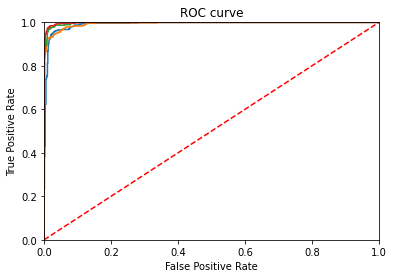

NameError: ignored

In [ ]:
clf = ANN((512,))
results = test_USE(sa_texts, sa_classes, clf, "SpamAssassin", "ANN", plot_graphics=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

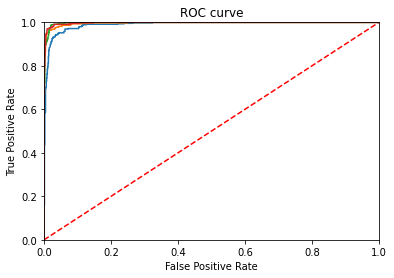

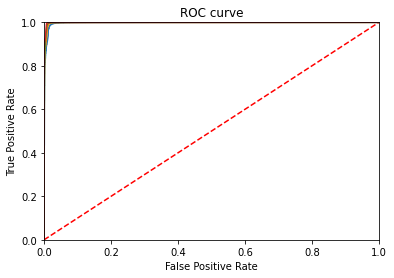

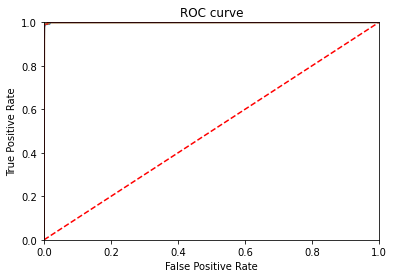

In [ ]:
results = test_USE(trec_texts, trec_classes, clf, "TREC", "ANN", plot_graphics=True)
results = test_USE(ceas_texts, ceas_classes, clf, "CEAS", "ANN", plot_graphics=True)

# USE+CNN

In [ ]:
import cv2

def embed_attachment(attachments):
  embeddings = np.zeros((len(attachments), 1280))
  for i, attachment_list in enumerate(attachments):
    attachment = next((att for att in attachment_list if att[1] != '' and att[1] != 'gif'), ['', ''])
    if attachment[1] != '':
      with open('/content/attachment.' + attachment[1], "wb+") as f:
        f.write(attachment[0])
      try:
        image = cv2.imread('/content/attachment.' + attachment[1])
        image = cv2.resize(image, (224, 224))
        image = np.reshape(image, (1, 224, 224, 3))
      except Exception:
        continue
      embedder_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top = False)
      embeddings[i] = embedder_model.predict(image)
  return embeddings
      

def CNNUSE(texts, attachments, classes, clf, dataset_prefix, classifier_prefix, n_iterations = 20, n_splits=4, normalization=False, plot_graphics=False):
  if plot_graphics:
    plt.figure()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC curve")
  acc = []
  roc = []
  model = SentenceTransformer('distiluse-base-multilingual-cased', device='cuda')
  attachment_embeddings = embed_attachment(attachments)
  text_embeddings = model.encode(texts)
  if normalization == True:
      scaler = Normalizer()
      text_embeddings = scaler.fit_transform(text_embeddings)
  input_embeddings = np.concatenate((text_embeddings, attachment_embeddings), axis=1) 
  for i in range(n_splits):
    X_train, X_test, y_train, y_test = train_test_split(input_embeddings, classes, test_size=0.33)
    clf.fit(X_train, y_train, epochs=n_iterations, validation_split=0.2, verbose=0)
    if plot_graphics:
      fpr, tpr, threshold = roc_curve(y_test, clf.predict(X_test))
      plt.plot(fpr, tpr)
    acc.append(accuracy_score(y_test, (clf.predict(X_test) > 0.5).astype(int)))
    roc.append(roc_auc_score(y_test, clf.predict(X_test)))
  if plot_graphics:
    plt.show()
  return results.append(pd.DataFrame({'Embedding': ['CNNUSE'], 'Classifier': [classifier_prefix], 'Dataset': [dataset_prefix], 'Accuracy': [np.mean(acc)], 'Accuracy_IQR': [scipy.stats.iqr(acc)], 'ROC_AUC': [np.mean(roc)], 'ROC_AUC_IQR': [scipy.stats.iqr(roc)], 'Splits': [n_splits], 'Date': [datetime.today().strftime('%Y-%m-%d-%H:%M:%S')]}))

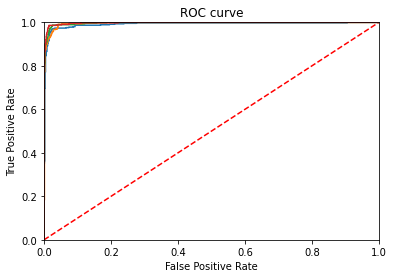

In [ ]:
clf = ANN((512+1280, ))
results = CNNUSE(sa_texts, sa_attachments, sa_classes, clf, "SpamAssassin", "ANN", plot_graphics=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

17620992/17605208 [==============================] - 0s 0us/step


KeyboardInterrupt: ignored

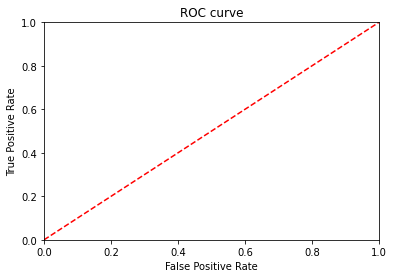

In [ ]:
clf = ANN((512+1280, ))
results = CNNUSE(trec_texts, trec_attachments, trec_classes, clf, "TREC", "ANN", plot_graphics=True)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

17620992/17605208 [==============================] - 0s 0us/step


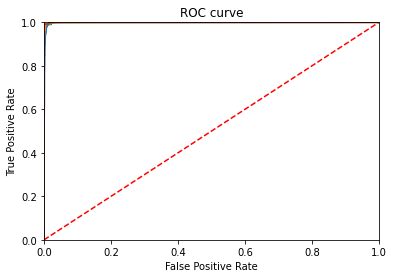

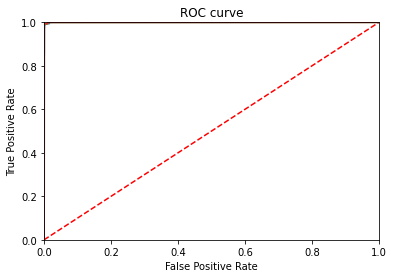

In [ ]:
clf = ANN((512+1280, ))
results = CNNUSE(ceas_texts1, ceas_attachments1, ceas_classes1, clf, "CEAS_1", "ANN", plot_graphics=True)
results.to_csv("/content/drive/My Drive/results.csv")
results = CNNUSE(ceas_texts2, ceas_attachments2, ceas_classes2, clf, "CEAS_2", "ANN", plot_graphics=True)
results.to_csv("/content/drive/My Drive/results.csv")

# Результаты

In [ ]:
results

,Unnamed: 0,Unnamed: 0.1,Embedding,Classifier,Dataset,Accuracy,Accuracy_IQR,ROC_AUC,ROC_AUC_IQR,Splits,Date
0,0.0,0.0,CNNUSE,ANN,TREC,0.990538,0.004038,0.998336,0.001079,4.0,2021-10-12-19:32:51
1,0.0,NaN,CNNUSE,ANN,SpamAssassin,0.975469,0.007937,0.995523,0.002541,4.0,2021-10-19-23:24:43
0,NaN,NaN,CNNUSE,ANN,CEAS_1,0.994715,0.001754,0.999346,0.000380,4.0,2021-10-27-10:24:20
0,NaN,NaN,CNNUSE,ANN,CEAS_2,0.997137,0.000431,0.999654,0.000391,4.0,2021-10-27-12:00:36


In [ ]:
results.to_csv("results.csv")

In [ ]:
results.to_csv("/content/drive/My Drive/results.csv")

# **Алгоритмы выбора признаков**

## TFDCR

In [ ]:
INF = 1000000000
N_FEATURES = 10000
UNIQUE_FEATURE_THR = 50


"""
Afgorithm TFDCR of feature selection
"""
def tfdcr(tokens, classes, vectorizer='bow'):
  features = np.unique(np.concatenate(tokens, axis=None))
  features_weight = np.zeros(len(features))
  leg_docs = np.array([tokens[i] for i in range(len(tokens)) if not classes[i]])
  spam_docs = np.array([tokens[i] for i in range(len(tokens)) if classes[i]])
  counter_leg = [Counter(email) for email in leg_docs]
  counter_spam = [Counter(email) for email in spam_docs]
  counter_all = [Counter(email) for email in tokens]
  for i, term in enumerate(features):
    term_freq_spam = 0
    term_freq_leg = 0
    doc_freq_spam = 0
    doc_freq_leg = 0
    for j in range(len(leg_docs)):
        if counter_leg[j][term] != 0:
            doc_freq_leg += 1
            term_freq_leg += counter_leg[j][term]
    for j in range(len(spam_docs)):
        if counter_spam[j][term] != 0:
            doc_freq_spam += 1
            term_freq_spam += counter_spam[j][term]
    if doc_freq_leg == 0 or doc_freq_spam == 0:
      if term_freq_leg + term_freq_spam >= UNIQUE_FEATURE_THR:
        features_weight[i] = INF
      else:
        features_weight[i] = 0
    else:
      product = doc_freq_spam / len(spam_docs) * len(leg_docs) / doc_freq_leg if doc_freq_spam / len(spam_docs) > doc_freq_leg / len(leg_docs) else doc_freq_leg / len(leg_docs) * len(spam_docs) / doc_freq_spam
      features_weight[i] = np.abs(term_freq_leg - term_freq_spam) * product
  ids = features_weight.argsort()
  best_features = features[ids[::-1]][:min(N_FEATURES, len(features)):]
  vectors = np.zeros((len(tokens), len(best_features)))
  for i in range(len(tokens)):
    for j in range(len(best_features)):
      vectors[i][j] = counter_all[i][best_features[j]]
  if vectorizer == "bow":
    return vectors
  elif vectorizer == "tfidf":
    tfidf  = TfidfTransformer()
    return tfidf.fit_transform(vectors, classes)
  elif vectorizer == "tf":
    tf  = TfidfTransformer(use_idf = False)
    return tf.fit_transform(vectors, classes)

## WOA


In [ ]:
# #ALPHA = 0.5
# #BETA = 0.5

# def find_best_solution(features, classes, whales, validation_X, validation_y):
#   clf = KNeighborsClassifier()
#   ans = None
#   best_score = 0
#   for whale in whales:
#     print(1)
#     cur_features = features[:, whale.astype(np.bool)]
#     clf.fit(cur_features, classes)
#     score = clf.score(validation_X[:, whale.astype(np.bool)], validation_y)
#     score = ALPHA * (1 - score) + BETA * len(cur_features[0]) / len(features[0])
#     if score < best_score:
#       best_score = score
#       ans = whale
#   return ans


# def woa(features, classes, n_whales, validation_X, validation_y, max_iters, B):
#   whales = np.random.randint(0, 2, (n_whales, len(features[0])))
#   prey = find_best_solution(features, classes, whales, validation_X, validation_y)
#   for t in range(max_iters):
#     print(t)
#     a = 2 - 2 * t / max_iters
#     for i in len(whales):
#       r = np.random.random(len(whales[0]))
#       print(r)
#       A = 2 * a * r - a
#       C = 2 * r
#       if (np.random.random() >= 0.5):
#         D = np.abs(whales[i] - prey)
#         l = np.random.random() * 2.0 - 1
#         whales[i] = D * np.exp(B * l) * np.cos(2 * np.pi * l) + prey
#       elif np.linalg.norm(A) < 1:
#         D = np.abs(C * prey - whales[i])
#         whales[i] = prey - A * D
#       else:
#         rand_whale = whales[np.random.randint(0, n_whales)]
#         D = np.abs(C * rand_whale - whales[i])
#         whales[i] = rand_whale - A * D
#       whales[i] = (whales[i] >= 0.5).astype('int')
#     prey = find_best_solution(features, classes, whales, validation_X, validation_y)
#   return features[:, prey.astype(np.bool)]

In [ ]:
# def do_tests_with_woa(clf, texts, classes, out_prefix):
#   with tf.device('/device:GPU:0'):
#     cv = CountVectorizer(tokenizer=tmp, preprocessor=tmp)
#     vecs = cv.fit_transform(get_tokens_arr(texts)).toarray()
#     X, X_val, y, y_val = train_test_split(vecs, classes, test_size=0.33)
#     print(woa(X, y, 10, X_val, y_val, 12, 1))

# do_tests_with_woa(1, sa_texts, sa_classes, "")

In [ ]:
"""
Tokenize and lemmatize document
"""
def tokenize_and_lemmatize(raw_text):
    regex = re.compile('[^a-zA-Z ]')
    raw_text = regex.sub(' ', raw_text)
    tokens = nltk.word_tokenize(raw_text.lower())
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]     
    return tokens

def get_tokens_arr(email_texts):
  tokens_arr = []
  for raw_text in email_texts:
    tokens_arr.append(tokenize_and_lemmatize(raw_text.lower()))
  return tokens_arr

In [ ]:
sa_tokens = get_tokens_arr(sa_raw_texts)
print(np.sum(list(map(lambda x: len(x), sa_tokens))))

2561672


# **Тесты**

## Код моделей

In [ ]:
from sklearn.preprocessing import Normalizer;

def dummy(data):
  return data

def do_tests_with_clf(clf, texts, classes, out_prefix, n_features=N_FEATURES, vectorizer="tfidf", selector="all"):
  with tf.device('/device:GPU:0'):
    warnings.filterwarnings('ignore')
    vect = None
    select = None
    if vectorizer == "tfidf":
      vect = TfidfVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "bow":
      vect = CountVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "tf":
      vect = TfidfVectorizer(use_idf = False, tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    
    
    if selector == "tfdcr" or selector == "all":
      acc = []
      roc = []
      for i in range(4):
        train_X, test_X, train_y, test_y = train_test_split(tfdcr(get_tokens_arr(texts), classes, vectorizer=vectorizer), classes * 2 - 1, test_size=0.33)
        clf.fit(train_X, train_y)
        acc.append(clf.score(test_X, test_y))
        roc.append(roc_auc_score(test_y, clf.predict(test_X)))
      print(("{} TFDCR: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

    if selector == "chi" or selector == "all":
      chi = SelectKBest(chi2, k=n_features)
      acc = []
      roc = []
      for i in range(4):
        train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
        train_X = chi.fit_transform(vect.fit_transform(train_X).toarray(), train_y)
        test_X = chi.transform(vect.transform(test_X).toarray())
        gc.collect()
        clf.fit(train_X, train_y)
        acc.append(clf.score(test_X, test_y))
        roc.append(roc_auc_score(test_y, clf.predict(test_X)))
      print(("{} CHI2: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))
  
    if selector == 'none':
      acc = []
      roc = []
      for i in range(4):
        train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
        train_X = vect.fit_transform(train_X).toarray()
        test_X = vect.transform(test_X).toarray()
        clf.fit(train_X, train_y)
        acc.append(clf.score(test_X, test_y))
        roc.append(roc_auc_score(test_y, clf.predict(test_X)))
      print(("{} NO SELEC: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))


def do_normtests_with_clf(clf, texts, classes, out_prefix, n_features=N_FEATURES, vectorizer="tfidf", selector="all"):
  with tf.device('/device:GPU:0'):
    warnings.filterwarnings('ignore')
    vect = None
    select = None
    if vectorizer == "tfidf":
      vect = TfidfVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "bow":
      vect = CountVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "tf":
      vect = TfidfVectorizer(use_idf = False, tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    
    scaler = Normalizer();
    if selector == "tfdcr" or selector == "all":
      acc = []
      roc = []
      for i in range(4):
        train_X, test_X, train_y, test_y = train_test_split(tfdcr(get_tokens_arr(texts), classes, vectorizer=vectorizer), classes * 2 - 1, test_size=0.33)
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        clf.fit(train_X, train_y)
        acc.append(clf.score(test_X, test_y))
        roc.append(roc_auc_score(test_y, clf.predict(test_X)))
      print(("{} NORM TFDCR: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

    if selector == "chi" or selector == "all":
      chi = SelectKBest(chi2, k=n_features)
      acc = []
      roc = []
      for i in range(4):
        train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
        train_X = chi.fit_transform(vect.fit_transform(train_X).toarray(), train_y)
        test_X = chi.transform(vect.transform(test_X).toarray())
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        gc.collect()
        clf.fit(train_X, train_y)
        acc.append(clf.score(test_X, test_y))
        roc.append(roc_auc_score(test_y, clf.predict(test_X)))
      print(("{} NORM CHI2: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))
  
    if selector == 'none':
      acc = []
      roc = []
      for i in range(4):
        train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
        train_X = vect.fit_transform(train_X).toarray()
        test_X = vect.transform(test_X).toarray()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        clf.fit(train_X, train_y)
        acc.append(clf.score(test_X, test_y))
        roc.append(roc_auc_score(test_y, clf.predict(test_X)))
      print(("{} NO SELEC: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))


def do_onenormtests_with_clf(clf, texts, classes, out_prefix, n_features=N_FEATURES, vectorizer="tfidf", selector="all"):
  with tf.device('/device:GPU:0'):
    warnings.filterwarnings('ignore')
    vect = None
    select = None
    if vectorizer == "tfidf":
      vect = TfidfVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "bow":
      vect = CountVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "tf":
      vect = TfidfVectorizer(use_idf = False, tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    
    scaler = Normalizer();
    if selector == "tfdcr" or selector == "all":
      train_X, test_X, train_y, test_y = train_test_split(tfdcr(get_tokens_arr(texts), classes, vectorizer=vectorizer), classes * 2 - 1, test_size=0.33)
      train_X = scaler.fit_transform(train_X)
      test_X = scaler.transform(test_X)
      clf.fit(train_X, train_y)
      print(("{} NORM TFDCR: accuracy={} roc_auc={}").format(out_prefix, clf.score(test_X, test_y), roc_auc_score(test_y, clf.predict(test_X))))

    if selector == "chi" or selector == "all":
      chi = SelectKBest(chi2, k=n_features)
      train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
      train_X = chi.fit_transform(vect.fit_transform(train_X).toarray(), train_y)
      test_X = chi.transform(vect.transform(test_X).toarray())
      train_X = scaler.fit_transform(train_X)
      test_X = scaler.transform(test_X)
      gc.collect()
      clf.fit(train_X, train_y)
      print(("{} NORM CHI2: accuracy={} roc_auc={}").format(out_prefix, clf.score(test_X, test_y), roc_auc_score(test_y, clf.predict(test_X))))
  
    if selector == 'none':
      acc = []
      roc = []
      for i in range(4):
        train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
        train_X = vect.fit_transform(train_X).toarray()
        test_X = vect.transform(test_X).toarray()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        clf.fit(train_X, train_y)
        acc.append(clf.score(test_X, test_y))
        roc.append(roc_auc_score(test_y, clf.predict(test_X)))
      print(("{} NO SELEC: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))


def test_doc2vec(clf, texts, classes, out_prefix):
  acc = []
  roc = []
  for i in range(4):
    train_X, test_X, train_y, test_y = train_test_split(get_tokens_arr(texts), classes * 2 - 1, test_size=0.33)
    train_corpus = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(train_X)]
    model = Doc2Vec(dm=0, vector_size=500, workers=4, epochs=100)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    vecs_train = [model.infer_vector(doc) for doc in train_X]
    vecs_test = [model.infer_vector(doc) for doc in test_X]
    clf.fit(vecs_train, train_y)
    acc.append(clf.score(vecs_test, test_y))
    roc.append(roc_auc_score(test_y, clf.predict(vecs_test)))
  print(("{} Doc2vec: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

def test_use(clf, texts, classes, out_prefix):
  acc = []
  roc = []
  model = SentenceTransformer('distiluse-base-multilingual-cased', device='cuda')
  for i in range(4):
    train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
    vecs_train = model.encode(train_X)
    vecs_test = model.encode(test_X)
    clf.fit(vecs_train, train_y)
    acc.append(clf.score(vecs_test, test_y))
    roc.append(roc_auc_score(test_y, clf.predict(vecs_test)))
  print(("{} USE: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

def test_normuse(clf, texts, classes, out_prefix):
  acc = []
  roc = []
  model = SentenceTransformer('distiluse-base-multilingual-cased', device='cuda')
  for i in range(4):
    train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
    vecs_train = model.encode(train_X)
    vecs_test = model.encode(test_X)
    scaler = Normalizer()
    vecs_train = scaler.fit_transform(vecs_train)
    vecs_test = scaler.transform(vecs_test)
    clf.fit(vecs_train, train_y)
    acc.append(clf.score(vecs_test, test_y))
    roc.append(roc_auc_score(test_y, clf.predict(vecs_test)))
  print(("{} USE: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

def onetest_normuse(clf, texts, classes, out_prefix):
  model = SentenceTransformer('distiluse-base-multilingual-cased', device='cuda')
  train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
  vecs_train = model.encode(train_X)
  vecs_test = model.encode(test_X)
  scaler = Normalizer()
  vecs_train = scaler.fit_transform(vecs_train)
  vecs_test = scaler.transform(vecs_test)
  clf.fit(vecs_train, train_y)
  print(("{} USE: accuracy={} roc_auc={}").format(out_prefix, clf.score(vecs_test, test_y), roc_auc_score(test_y, clf.predict(vecs_test))))

  #model = SentenceTransformer('bert-large-nli-mean-tokens', device = 'cuda')
  #train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
  #vecs_train = model.encode(train_X)
  #vecs_test = model.encode(test_X)
  #clf.fit(vecs_train, train_y)
  #print(("{} BERT: accuracy={} roc_auc={}").format(out_prefix, clf.score(vecs_test, test_y), roc_auc_score(test_y, clf.predict(vecs_test))))

  #model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens', device = 'cuda')
  #train_X, test_X, train_y, test_y = train_test_split(texts, classes * 2 - 1, test_size=0.33)
  #vecs_train = model.encode(train_X)
  #vecs_test = model.encode(test_X)
  #clf.fit(vecs_train, train_y)
  #print(("{} ROBERTA: accuracy={} roc_auc={}").format(out_prefix, clf.score(vecs_test, test_y), roc_auc_score(test_y, clf.predict(vecs_test))))

In [ ]:
warnings.filterwarnings('ignore')
model = Sequential()
model.add(Dense(30, input_shape=(512,), activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

def turn_one_hot(classes):
  new_classes = []
  for ex in classes:
    new_classes.append([0, 0])
    new_classes[-1][ex] = 1
  return np.array(new_classes)

def test_use_nn(clf, texts, classes, out_prefix):
  model = SentenceTransformer('distiluse-base-multilingual-cased', device = 'cuda')
  acc = []
  roc = []
  for i in range(4):
    train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
    vecs_train = model.encode(train_X)
    vecs_test = model.encode(test_X)
    clf.fit(vecs_train, train_y, epochs=30, verbose=0)
    res = clf.evaluate(vecs_test, test_y, verbose=0)
    acc.append(res[1])
    roc.append(res[2])
  print(("{} USE: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

In [ ]:
warnings.filterwarnings('ignore')
model = Sequential()
model.add(Dense(30, input_shape=(3000,), activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

def turn_one_hot(classes):
  new_classes = []
  for ex in classes:
    new_classes.append([0, 0])
    new_classes[-1][ex] = 1
  return np.array(new_classes)

def test_nn(clf, texts, classes, out_prefix, n_features=3000, vectorizer="tfidf"):
    vect = None
    if vectorizer == "tfidf":
      vect = TfidfVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "bow":
      vect = CountVectorizer(tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    elif vectorizer == "tf":
      vect = TfidfVectorizer(use_idf = False, tokenizer=tokenize_and_lemmatize, preprocessor=dummy)
    chi = SelectKBest(chi2, k=n_features)
    acc = []
    roc = []
    for i in range(4):
      train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
      train_X = chi.fit_transform(vect.fit_transform(train_X).toarray(), train_y)
      test_X = chi.transform(vect.transform(test_X).toarray())
      gc.collect()
      clf.fit(train_X, train_y, epochs=30, verbose=0)
      res = clf.evaluate(test_X, test_y, verbose=0)
      acc.append(res[1])
      roc.append(res[2])
    print(("{}: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

In [ ]:
def get_cnn_model(max_len, ndim, n_grams=[2, 3, 5]):
  i = Input(shape=(max_len, 50))
  branches = []
  for n in n_grams:
    branch = Conv1D(filters=ndim, kernel_size=n, activation='relu')(i)
    branch = MaxPooling1D(pool_size=10, strides=None, padding='valid')(branch)
    branch = Flatten()(branch)
    branches.append(branch)
  x = concatenate(branches, axis=-1)
  x = Dropout(0.5)(x)
  x = Dense(2, activation='softmax')(x)
  model = Model(inputs=i, outputs=x)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
  return model

def test_cnn(texts, classes, out_prefix):
  texts = get_tokens_arr(texts)
  #max_len = np.max([len(sent) for sent in texts])
  acc = []
  roc = []
  for i in range(4):
    train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
    ft = Word2Vec(sentences=train_X, size=50, window=5, min_count=1, workers=4, iter=40)
    ft.build_vocab(test_X, update=True)
    ft.train(test_X, epochs=ft.iter, total_examples=ft.corpus_count)
    max_len = 400
    train_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in train_X], maxlen=max_len)
    test_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in test_X], maxlen=max_len)
    gc.collect()
    clf = get_cnn_model(max_len, 128)
    clf.fit(train_X, train_y, epochs=50, verbose=0)
    res = clf.evaluate(test_X, test_y, verbose=0)
    acc.append(res[1])
    roc.append(res[2])
  print(("{}: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))

## Normalizer SVC BOW

In [ ]:
do_normtests_with_clf(svm, sa_texts, sa_classes, "SVC SA", vectorizer="bow")

SVC SA NORM TFDCR: accuracy=0.9742063492063493(0.004509379509379352) roc_auc=0.9697992845989967(0.007982521733865267)
SVC SA NORM CHI2: accuracy=0.9761904761904762(0.00649350649350644) roc_auc=0.9709070091021035(0.007339439064745101)


In [ ]:
do_normtests_with_clf(svm, en1t, en1c, "SVC EN1", vectorizer="bow")
do_normtests_with_clf(svm, en2t, en2c, "SVC EN2", vectorizer="bow")
do_normtests_with_clf(svm, en3t, en3c, "SVC EN3", vectorizer="bow")
do_normtests_with_clf(svm, en4t, en4c, "SVC EN4", vectorizer="bow")

SVC EN1 NORM TFDCR: accuracy=0.9818394844756884(0.0014645577035735657) roc_auc=0.9841997479058088(0.0015767262951638106)
SVC EN1 NORM CHI2: accuracy=0.981693028705331(0.002782659636789586) roc_auc=0.9842208072381706(0.0027005628325905695)
SVC EN2 NORM TFDCR: accuracy=0.9893947232281428(0.0012933264355923235) roc_auc=0.9866050809381676(0.001484829585955194)
SVC EN2 NORM CHI2: accuracy=0.9887480600103467(0.0011639937920329135) roc_auc=0.9853653860936372(0.001206872008405413)
SVC EN3 NORM TFDCR: accuracy=0.9924409015942826(0.00123694337548097) roc_auc=0.9898326277552015(0.002608429393732181)
SVC EN3 NORM CHI2: accuracy=0.988455195162177(0.0005497526113249496) roc_auc=0.9843499133599825(0.0014629516722935998)
SVC EN4 NORM TFDCR: accuracy=0.9808080808080808(0.0012626262626262985) roc_auc=0.960973311029489(0.0030084998372142957)
SVC EN4 NORM CHI2: accuracy=0.9871212121212121(0.0037878787878787845) roc_auc=0.9743462022360592(0.007192735794045779)


In [ ]:
do_normtests_with_clf(svm, en5t, en5c, "SVC EN5", vectorizer="bow")
do_normtests_with_clf(svm, en6t, en6c, "SVC EN6", vectorizer="bow")

SVC EN5 NORM TFDCR: accuracy=0.990632318501171(0.0002927400468384356) roc_auc=0.9845062862113693(0.0007309220827049767)
SVC EN5 NORM CHI2: accuracy=0.9926814988290398(0.002049180327868827) roc_auc=0.9878139335819087(0.002638569123175838)
SVC EN6 NORM TFDCR: accuracy=0.984469696969697(0.001388888888888884) roc_auc=0.9705444630679557(0.0021813359243275654)
SVC EN6 NORM CHI2: accuracy=0.9842171717171718(0.0031565656565657463) roc_auc=0.9705982031235574(0.005290794836100954)


In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, ceas1_texts, ceas1_classes, "SVM CEAS1", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, ceas2_texts, ceas2_classes, "SVM CEAS2", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, ceas3_texts, ceas3_classes, "SVM CEAS3", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, ceas4_texts, ceas4_classes, "SVM CEAS4", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, ceas5_texts, ceas5_classes, "SVM CEAS5", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, ceas7_texts, ceas7_classes, "SVM CEAS7", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, ceas8_texts, ceas8_classes, "SVM CEAS8", 4000, vectorizer="bow")

SVM CEAS1 NORM TFDCR: accuracy=0.9912174961253659 roc_auc=0.9790396383399428
SVM CEAS1 NORM CHI2: accuracy=0.9917341140003444 roc_auc=0.9832827320273025
SVM CEAS2 NORM TFDCR: accuracy=0.9908730842087137 roc_auc=0.9799390488603186
SVM CEAS2 NORM CHI2: accuracy=0.9920785259169967 roc_auc=0.9831775588748043
SVM CEAS3 NORM TFDCR: accuracy=0.9908730842087137 roc_auc=0.9803989562363887
SVM CEAS3 NORM CHI2: accuracy=0.9915619080420183 roc_auc=0.9809074125157778
SVM CEAS4 NORM TFDCR: accuracy=0.9915619080420183 roc_auc=0.982255441605346
SVM CEAS4 NORM CHI2: accuracy=0.9910452901670398 roc_auc=0.9782630851127971
SVM CEAS5 NORM TFDCR: accuracy=0.9888085399449036 roc_auc=0.9755210051017122
SVM CEAS5 NORM CHI2: accuracy=0.9925964187327824 roc_auc=0.9837561302339918
SVM CEAS7 NORM TFDCR: accuracy=0.9924242424242424 roc_auc=0.9821341159002328
SVM CEAS7 NORM CHI2: accuracy=0.9915633608815427 roc_auc=0.983085117684369
SVM CEAS8 NORM TFDCR: accuracy=0.9907024793388429 roc_auc=0.9820087387812944
SVM CEA

In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, trec1_texts, trec1_classes, "SVM trec1", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, trec2_texts, trec2_classes, "SVM trec2", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, trec3_texts, trec3_classes, "SVM trec3", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, trec4_texts, trec4_classes, "SVM trec4", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, trec5_texts, trec5_classes, "SVM trec5", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, trec6_texts, trec6_classes, "SVM trec6", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, trec7_texts, trec7_classes, "SVM trec7", 4000, vectorizer="bow")
gc.collect()
do_onenormtests_with_clf(svm, trec8_texts, trec8_classes, "SVM trec8", 4000, vectorizer="bow")
gc.collect()

SVM trec1 NORM TFDCR: accuracy=0.9871423979427837 roc_auc=0.9823862858086415
SVM trec1 NORM CHI2: accuracy=0.9864995178399228 roc_auc=0.9811474852604142
SVM trec2 NORM TFDCR: accuracy=0.984254498714653 roc_auc=0.978157438134708
SVM trec2 NORM CHI2: accuracy=0.9823264781491002 roc_auc=0.9755289212459177
SVM trec3 NORM TFDCR: accuracy=0.9881067180970748 roc_auc=0.9818869502504225
SVM trec3 NORM CHI2: accuracy=0.9852137576342013 roc_auc=0.9791772634190339
SVM trec4 NORM TFDCR: accuracy=0.9839279974284796 roc_auc=0.9779163620985653
SVM trec4 NORM CHI2: accuracy=0.9823207971713276 roc_auc=0.9767089027861688
SVM trec5 NORM TFDCR: accuracy=0.9839279974284796 roc_auc=0.9778337084782757
SVM trec5 NORM CHI2: accuracy=0.9861780777884924 roc_auc=0.9813009762728621
SVM trec6 NORM TFDCR: accuracy=0.9887495981999357 roc_auc=0.9842561476778995
SVM trec6 NORM CHI2: accuracy=0.9829636772741883 roc_auc=0.9765108258574653
SVM trec7 NORM TFDCR: accuracy=0.9826478149100257 roc_auc=0.9758313584517176
SVM tre

0

## Normalizer SVC TF

In [ ]:
do_normtests_with_clf(svm, sa_texts, sa_classes, "SVC SA", vectorizer="tf")
do_normtests_with_clf(svm, en1t, en1c, "SVC EN1", vectorizer="tf")
do_normtests_with_clf(svm, en2t, en2c, "SVC EN2", vectorizer="tf")
do_normtests_with_clf(svm, en3t, en3c, "SVC EN3", vectorizer="tf")
do_normtests_with_clf(svm, en4t, en4c, "SVC EN4", vectorizer="tf")

SVC SA NORM TFDCR: accuracy=0.9752886002886003(0.001984126984126977) roc_auc=0.9704559352544695(0.004003588647823353)
SVC SA NORM CHI2: accuracy=0.9754689754689755(0.006132756132756101) roc_auc=0.9698393206650793(0.007134089626467555)
SVC EN1 NORM TFDCR: accuracy=0.9818394844756884(0.0017574692442882123) roc_auc=0.984407630571824(0.0018911819566259647)
SVC EN1 NORM CHI2: accuracy=0.9828646748681898(0.0051259519625073136) roc_auc=0.9833385298258395(0.0037390124805984915)
SVC EN2 NORM TFDCR: accuracy=0.9913347128815313(0.0014226590791515115) roc_auc=0.9886791892298505(0.0017830231440790767)
SVC EN2 NORM CHI2: accuracy=0.9897827211588206(0.002715985514744057) roc_auc=0.9868440940517561(0.0018391608054767472)
SVC EN3 NORM TFDCR: accuracy=0.9903793293018142(0.0002748763056624748) roc_auc=0.9860416689570004(0.0010427778340078575)
SVC EN3 NORM CHI2: accuracy=0.9891423859263331(0.0028862012094558187) roc_auc=0.9839939781716237(0.003545951443982065)
SVC EN4 NORM TFDCR: accuracy=0.98194444444444

In [ ]:
do_normtests_with_clf(svm, en5t, en5c, "SVC EN5", vectorizer="tf")
do_normtests_with_clf(svm, en6t, en6c, "SVC EN6", vectorizer="tf")

SVC EN5 NORM TFDCR: accuracy=0.9910714285714286(0.003951990632318436) roc_auc=0.9852145814825642(0.007276354151050213)
SVC EN5 NORM CHI2: accuracy=0.9926814988290398(0.0011709601873537423) roc_auc=0.9871993603847597(0.0023308060762433636)
SVC EN6 NORM TFDCR: accuracy=0.9801767676767678(0.00037878787878786735) roc_auc=0.9616208336114901(0.0007910496011471757)
SVC EN6 NORM CHI2: accuracy=0.9833333333333333(0.003030303030302939) roc_auc=0.968509032446804(0.005069408409578258)


In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, ceas1_texts, ceas1_classes, "SVM CEAS1", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, ceas2_texts, ceas2_classes, "SVM CEAS2", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, ceas3_texts, ceas3_classes, "SVM CEAS3", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, ceas4_texts, ceas4_classes, "SVM CEAS4", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, ceas5_texts, ceas5_classes, "SVM CEAS5", 4000, vectorizer="tf")

SVM CEAS1 NORM TFDCR: accuracy=0.9929395557086275 roc_auc=0.9837159479207467
SVM CEAS1 NORM CHI2: accuracy=0.9908730842087137 roc_auc=0.9819929601309219
SVM CEAS2 NORM TFDCR: accuracy=0.9915619080420183 roc_auc=0.9830382921988994
SVM CEAS2 NORM CHI2: accuracy=0.990184260375409 roc_auc=0.979828425755537
SVM CEAS3 NORM TFDCR: accuracy=0.9913897020836921 roc_auc=0.9806738119586651
SVM CEAS3 NORM CHI2: accuracy=0.9908730842087137 roc_auc=0.9820716218505736
SVM CEAS4 NORM TFDCR: accuracy=0.9919063199586706 roc_auc=0.9811370259623143
SVM CEAS4 NORM CHI2: accuracy=0.9919063199586706 roc_auc=0.9828113043088387
SVM CEAS5 NORM TFDCR: accuracy=0.9925964187327824 roc_auc=0.9836500384678691
SVM CEAS5 NORM CHI2: accuracy=0.990530303030303 roc_auc=0.9798140098365469


In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, ceas7_texts, ceas7_classes, "SVM CEAS7", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, ceas8_texts, ceas8_classes, "SVM CEAS8", 4000, vectorizer="tf")

SVM CEAS7 NORM TFDCR: accuracy=0.9915633608815427 roc_auc=0.9787723024638912
SVM CEAS7 NORM CHI2: accuracy=0.9891528925619835 roc_auc=0.9764673244625602
SVM CEAS8 NORM TFDCR: accuracy=0.9917355371900827 roc_auc=0.9810318920266565
SVM CEAS8 NORM CHI2: accuracy=0.9913911845730028 roc_auc=0.9843617146905999


In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, trec1_texts, trec1_classes, "SVM trec1", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, trec2_texts, trec2_classes, "SVM trec2", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, trec3_texts, trec3_classes, "SVM trec3", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, trec4_texts, trec4_classes, "SVM trec4", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, trec5_texts, trec5_classes, "SVM trec5", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, trec6_texts, trec6_classes, "SVM trec6", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, trec7_texts, trec7_classes, "SVM trec7", 4000, vectorizer="tf")
gc.collect()
do_onenormtests_with_clf(svm, trec8_texts, trec8_classes, "SVM trec8", 4000, vectorizer="tf")
gc.collect()

SVM trec1 NORM TFDCR: accuracy=0.9852137576342013 roc_auc=0.9797808012093726
SVM trec1 NORM CHI2: accuracy=0.9848923175827708 roc_auc=0.9776094742977476
SVM trec2 NORM TFDCR: accuracy=0.9839331619537275 roc_auc=0.9790349745533371
SVM trec2 NORM CHI2: accuracy=0.9861825192802056 roc_auc=0.9808457812634979
SVM trec3 NORM TFDCR: accuracy=0.9819993571198972 roc_auc=0.9736510616315286
SVM trec3 NORM CHI2: accuracy=0.9871423979427837 roc_auc=0.9835363351488473
SVM trec4 NORM TFDCR: accuracy=0.9794278367084539 roc_auc=0.9727105612971989
SVM trec4 NORM CHI2: accuracy=0.9813564770170363 roc_auc=0.9757054841585263
SVM trec5 NORM TFDCR: accuracy=0.9845708775313404 roc_auc=0.9788331949522241
SVM trec5 NORM CHI2: accuracy=0.9881067180970748 roc_auc=0.9833224530619505
SVM trec6 NORM TFDCR: accuracy=0.9852137576342013 roc_auc=0.9806647258612323
SVM trec6 NORM CHI2: accuracy=0.9816779170684667 roc_auc=0.9756981313606037
SVM trec7 NORM TFDCR: accuracy=0.9855398457583547 roc_auc=0.9803052411272256
SVM t

0

## Normalizer SVC TF/IDF(в результатах написано CERT - но это на самом деле SVC)


In [ ]:
do_normtests_with_clf(svm, sa_texts, sa_classes, "SVC SA", vectorizer="tfidf")
do_normtests_with_clf(svm, en1t, en1c, "SVC EN1", vectorizer="tfidf")
do_normtests_with_clf(svm, en2t, en2c, "SVC EN2", vectorizer="tfidf")
do_normtests_with_clf(svm, en3t, en3c, "SVC EN3", vectorizer="tfidf")
do_normtests_with_clf(svm, en4t, en4c, "SVC EN4", vectorizer="tfidf")
do_normtests_with_clf(svm, en5t, en5c, "SVC EN5", vectorizer="tfidf")

SVC SA NORM TFDCR: accuracy=0.9705988455988457(0.0063131313131311595) roc_auc=0.9618582222844192(0.008180529437204376)
SVC SA NORM CHI2: accuracy=0.9803391053391053(0.004148629148629124) roc_auc=0.9756853305796952(0.004246974614299903)
SVC EN1 NORM TFDCR: accuracy=0.9852079671939075(0.004247217340363152) roc_auc=0.9856997936743893(0.003701891070308827)
SVC EN1 NORM CHI2: accuracy=0.9853544229642648(0.0014645577035734547) roc_auc=0.9865241242014262(0.0015052059252049776)
SVC EN2 NORM TFDCR: accuracy=0.990688049663735(0.002327987584066271) roc_auc=0.9845489576463928(0.004197414516245779)
SVC EN2 NORM CHI2: accuracy=0.9903000517330575(0.0016813243662701094) roc_auc=0.9860026382395426(0.0023238206174314158)
SVC EN3 NORM TFDCR: accuracy=0.9899670148433205(0.001236943375480859) roc_auc=0.9834943349708408(0.0025617237413029237)
SVC EN3 NORM CHI2: accuracy=0.9925783397471137(0.0016492578339745156) roc_auc=0.9902753461289152(0.0017009413024685616)
SVC EN4 NORM TFDCR: accuracy=0.9795454545454546

In [ ]:
do_normtests_with_clf(svm, en6t, en6c, "SVC EN6", vectorizer="tfidf")

SVC EN6 NORM TFDCR: accuracy=0.9832070707070708(0.004419191919191934) roc_auc=0.9672725833500905(0.00761609967326371)
SVC EN6 NORM CHI2: accuracy=0.9859848484848485(0.001388888888888884) roc_auc=0.9732924006831423(0.0015906173657246336)


In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, ceas1_texts, ceas1_classes, "SVC CEAS1", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, ceas2_texts, ceas2_classes, "SVC CEAS2", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, ceas3_texts, ceas3_classes, "SVC CEAS3", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, ceas4_texts, ceas4_classes, "SVC CEAS4", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, ceas5_texts, ceas5_classes, "SVC CEAS5", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, ceas6_texts, ceas6_classes, "SVC CEAS6", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, ceas7_texts, ceas7_classes, "SVC CEAS7", 4000, vectorizer="tfidf")

SVC CEAS1 NORM TFDCR: accuracy=0.9931117616669537 roc_auc=0.984059853124312
SVC CEAS1 NORM CHI2: accuracy=0.9932839676252798 roc_auc=0.9871255267285197
SVC CEAS2 NORM TFDCR: accuracy=0.9905286722920613 roc_auc=0.9799150774213556
SVC CEAS2 NORM CHI2: accuracy=0.9907008782503874 roc_auc=0.9822353922809094
SVC CEAS3 NORM TFDCR: accuracy=0.9920785259169967 roc_auc=0.9817896047134598
SVC CEAS3 NORM CHI2: accuracy=0.9898398484587567 roc_auc=0.9834262486790066
SVC CEAS4 NORM TFDCR: accuracy=0.9900120544170828 roc_auc=0.9773943236144441
SVC CEAS4 NORM CHI2: accuracy=0.9913897020836921 roc_auc=0.9849596221781598
SVC CEAS5 NORM TFDCR: accuracy=0.9900137741046832 roc_auc=0.9770597623531332
SVC CEAS5 NORM CHI2: accuracy=0.9925964187327824 roc_auc=0.9865597262855159
SVC CEAS6 NORM TFDCR: accuracy=0.9912190082644629 roc_auc=0.9798412211919962
SVC CEAS6 NORM CHI2: accuracy=0.9920798898071626 roc_auc=0.9844653407297164
SVC CEAS7 NORM TFDCR: accuracy=0.990874655647383 roc_auc=0.9774824027751047
SVC CEA

In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, ceas8_texts, ceas8_classes, "SVC CEAS8", 4000, vectorizer="tfidf")

SVC CEAS8 NORM TFDCR: accuracy=0.9900137741046832 roc_auc=0.9792037420770356
SVC CEAS8 NORM CHI2: accuracy=0.9917355371900827 roc_auc=0.9840210148288642


In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, trec1_texts, trec1_classes, "SVC trec1", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, trec2_texts, trec2_classes, "SVC trec2", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, trec3_texts, trec3_classes, "SVC trec3", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, trec4_texts, trec4_classes, "SVC trec4", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, trec5_texts, trec5_classes, "SVC trec5", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, trec6_texts, trec6_classes, "SVC trec6", 4000, vectorizer="tfidf")
gc.collect()
do_onenormtests_with_clf(svm, trec7_texts, trec7_classes, "SVC trec7", 4000, vectorizer="tfidf")

SVC trec1 NORM TFDCR: accuracy=0.9852137576342013 roc_auc=0.9798972889432674
SVC trec1 NORM CHI2: accuracy=0.9871423979427837 roc_auc=0.9820125833650235
SVC trec2 NORM TFDCR: accuracy=0.9865038560411311 roc_auc=0.9817608899205508
SVC trec2 NORM CHI2: accuracy=0.9836118251928021 roc_auc=0.9787901970923739
SVC trec3 NORM TFDCR: accuracy=0.9848923175827708 roc_auc=0.9779644829254458
SVC trec3 NORM CHI2: accuracy=0.985856637737062 roc_auc=0.9807417469349535
SVC trec4 NORM TFDCR: accuracy=0.98424943747991 roc_auc=0.9778732708299093
SVC trec4 NORM CHI2: accuracy=0.982642237222758 roc_auc=0.9775467035268494
SVC trec5 NORM TFDCR: accuracy=0.9836065573770492 roc_auc=0.9768550545983091
SVC trec5 NORM CHI2: accuracy=0.9868209578913533 roc_auc=0.9838095830568457
SVC trec6 NORM TFDCR: accuracy=0.985856637737062 roc_auc=0.9803158590990854
SVC trec6 NORM CHI2: accuracy=0.989713918354227 roc_auc=0.9860936374392376
SVC trec7 NORM TFDCR: accuracy=0.984254498714653 roc_auc=0.9774678055496546
SVC trec7 NO

In [ ]:
gc.collect()
do_onenormtests_with_clf(svm, trec7_texts, trec7_classes, "SVC trec8", 4000, vectorizer="tfidf")

SVC trec8 NORM TFDCR: accuracy=0.9816838046272494 roc_auc=0.9751538552577076
SVC trec8 NORM CHI2: accuracy=0.9865038560411311 roc_auc=0.9826647730389678


## Normalizer SVC USE

In [ ]:
warnings.filterwarnings('ignore')
test_normuse(svm, sa_texts, sa_classes, "SVM SA")

SVM SA USE: accuracy=0.9693362193362193(0.005050505050505083) roc_auc=0.9653812890233215(0.004584051234466369)


In [ ]:
test_normuse(svm, en1t, en1c, "SVC EN1")
test_normuse(svm, en2t, en2c, "SVC EN2")

SVC EN1 USE: accuracy=0.9781780902167545(0.0030755711775044547) roc_auc=0.9754667502042889(0.003847829371480982)
SVC EN2 USE: accuracy=0.9855147439213657(0.00232798758406616) roc_auc=0.976980288279256(0.006847660546720924)


In [ ]:
test_normuse(svm, en3t, en3c, "SVC EN3")
test_normuse(svm, en4t, en4c, "SVC EN4")
test_normuse(svm, en5t, en5c, "SVC EN5")
test_normuse(svm, en6t, en6c, "SVC EN6")

SVC EN3 USE: accuracy=0.9898295766904892(0.0021990104452996873) roc_auc=0.9839028723151124(0.0019508796717071508)
SVC EN4 USE: accuracy=0.9875(0.0023989898989900116) roc_auc=0.9765116455070404(0.005035931042652431)
SVC EN5 USE: accuracy=0.9872658079625293(0.004244730679156983) roc_auc=0.9821290404206671(0.004797315075953157)
SVC EN6 USE: accuracy=0.9771464646464646(0.0021464646464646187) roc_auc=0.962214330055052(0.0015855734724350423)


In [ ]:
gc.collect()
onetest_normuse(svm, ceas1_texts, ceas1_classes, "SVC CEAS1")
gc.collect()
onetest_normuse(svm, ceas2_texts, ceas2_classes, "SVC CEAS2")
gc.collect()
onetest_normuse(svm, ceas3_texts, ceas3_classes, "SVC CEAS3")
gc.collect()
onetest_normuse(svm, ceas4_texts, ceas4_classes, "SVC CEAS4")
gc.collect()
onetest_normuse(svm, ceas5_texts, ceas5_classes, "SVC CEAS5")
gc.collect()
onetest_normuse(svm, ceas6_texts, ceas6_classes, "SVC CEAS6")
gc.collect()
onetest_normuse(svm, ceas7_texts, ceas7_classes, "SVC CEAS7")
gc.collect()
onetest_normuse(svm, ceas8_texts, ceas8_classes, "SVC CEAS8")

SVC CEAS1 USE: accuracy=0.9920785259169967 roc_auc=0.9838283281575698
SVC CEAS2 USE: accuracy=0.9908730842087137 roc_auc=0.9803817560234426
SVC CEAS3 USE: accuracy=0.9905286722920613 roc_auc=0.9786660398200346
SVC CEAS4 USE: accuracy=0.9929395557086275 roc_auc=0.9844918405268569
SVC CEAS5 USE: accuracy=0.9948347107438017 roc_auc=0.9879662359824475
SVC CEAS6 USE: accuracy=0.9924242424242424 roc_auc=0.9834467387867277
SVC CEAS7 USE: accuracy=0.9932851239669421 roc_auc=0.9838365778384472
SVC CEAS8 USE: accuracy=0.9915633608815427 roc_auc=0.9811619822631298


In [ ]:
gc.collect()
onetest_normuse(svm, trec1_texts, trec1_classes, "SVC trec1")
gc.collect()
onetest_normuse(svm, trec2_texts, trec2_classes, "SVC trec2")
gc.collect()
onetest_normuse(svm, trec3_texts, trec3_classes, "SVC trec3")
gc.collect()
onetest_normuse(svm, trec4_texts, trec4_classes, "SVC trec4")
gc.collect()
onetest_normuse(svm, trec5_texts, trec5_classes, "SVC trec5")
gc.collect()
onetest_normuse(svm, trec6_texts, trec6_classes, "SVC trec6")
gc.collect()
onetest_normuse(svm, trec7_texts, trec7_classes, "SVC trec7")
gc.collect()
onetest_normuse(svm, trec8_texts, trec8_classes, "SVC trec8")

SVC trec1 USE: accuracy=0.9765348762455802 roc_auc=0.97074669865723
SVC trec2 USE: accuracy=0.9720437017994858 roc_auc=0.9646841560866659
SVC trec3 USE: accuracy=0.9746062359369978 roc_auc=0.9697755264296649
SVC trec4 USE: accuracy=0.9787849566055931 roc_auc=0.9741123801499081
SVC trec5 USE: accuracy=0.9832851173256187 roc_auc=0.9800968985967529
SVC trec6 USE: accuracy=0.9729990356798457 roc_auc=0.9658948970560257
SVC trec7 USE: accuracy=0.9848971722365039 roc_auc=0.9812600257772586
SVC trec8 USE: accuracy=0.9797557840616966 roc_auc=0.9747440223227505


## CERT BOW

In [ ]:
do_tests_with_clf(cert, sa_texts, sa_classes, "CERT SA", vectorizer="bow")
do_tests_with_clf(cert, en1t, en1c, "CERT EN1", vectorizer="bow")
do_tests_with_clf(cert, en2t, en2c, "CERT EN2", vectorizer="bow")
do_tests_with_clf(cert, en3t, en3c, "CERT EN3", vectorizer="bow")
do_tests_with_clf(cert, en4t, en4c, "CERT EN4", vectorizer="bow")
do_tests_with_clf(cert, en5t, en5c, "CERT EN5", vectorizer="bow")
do_tests_with_clf(cert, en6t, en6c, "CERT EN6", vectorizer="bow")

CERT SA TFDCR: accuracy=0.9139610389610389(0.003427128427128334) roc_auc=0.9094306075608461(0.0029752328769090397)
CERT SA CHI2: accuracy=0.9157647907647908(0.01388888888888884) roc_auc=0.9148458155298682(0.010514472779473372)
CERT EN1 TFDCR: accuracy=0.9436145284124194(0.015084944346807183) roc_auc=0.9338894683158714(0.015616863184954699)
CERT EN1 CHI2: accuracy=0.9461042765084945(0.00702987697715296) roc_auc=0.932751974266106(0.010089377550614453)
CERT EN2 TFDCR: accuracy=0.956414899120538(0.007371960682876266) roc_auc=0.9464210052235165(0.012514524428477558)
CERT EN2 CHI2: accuracy=0.9546042421107087(0.006078634247284054) roc_auc=0.9337957439304174(0.010564266477019135)
CERT EN3 TFDCR: accuracy=0.9567069818581638(0.0028862012094558187) roc_auc=0.9429755123559161(0.0016082011083494718)
CERT EN3 CHI2: accuracy=0.9568444200109951(0.0030236393622870006) roc_auc=0.9488455131980382(0.009541576646162953)
CERT EN4 TFDCR: accuracy=0.9622474747474747(0.003409090909090917) roc_auc=0.9512078275

## SVC BOW

In [ ]:
do_tests_with_clf(svm, sa_texts, sa_classes, "SVC SA", vectorizer="bow")

SVC SA TFDCR: accuracy=0.7963564213564214(0.038419913419913465) roc_auc=0.695032022666193(0.07910816735785875)
SVC SA CHI2: accuracy=0.8246753246753247(0.0068542568542568905) roc_auc=0.7415188222465554(0.003070417710091089)
SVC EN1 TFDCR: accuracy=0.9686584651435267(0.003222026947861667) roc_auc=0.968906750397077(0.004486843353284975)


In [ ]:
do_tests_with_clf(svm, en1t, en1c, "SVC EN1", vectorizer="bow")
do_tests_with_clf(svm, en2t, en2c, "SVC EN2", vectorizer="bow")
do_tests_with_clf(svm, en3t, en3c, "SVC EN3", vectorizer="bow")
do_tests_with_clf(svm, en4t, en4c, "SVC EN4", vectorizer="bow")

SVC EN1 TFDCR: accuracy=0.9657293497363796(0.006444053895723556) roc_auc=0.9678741953921536(0.004138055062782531)
SVC EN1 CHI2: accuracy=0.9641183362624487(0.005125951962507536) roc_auc=0.9668987545291289(0.004520742693806645)
SVC EN2 TFDCR: accuracy=0.9745214692188308(0.002715985514743835) roc_auc=0.9559429155061088(0.0031489324964468768)
SVC EN2 CHI2: accuracy=0.9794361096740817(0.002457320227625459) roc_auc=0.9658681989777252(0.0037540133433157097)
SVC EN3 TFDCR: accuracy=0.8541781198460692(0.01745464540956554) roc_auc=0.738358793619815(0.03248935962009547)
SVC EN3 CHI2: accuracy=0.8413963716327653(0.011819681143485306) roc_auc=0.7119965749881201(0.010886228723825164)
SVC EN4 TFDCR: accuracy=0.9684343434343434(0.002020202020202033) roc_auc=0.9358272678938104(0.004061563665507251)
SVC EN4 CHI2: accuracy=0.9654040404040404(0.00479797979797969) roc_auc=0.9317000217894998(0.006894566236099409)


In [ ]:
do_tests_with_clf(svm, en5t, en5c, "SVC EN5", vectorizer="bow")
do_tests_with_clf(svm, en6t, en6c, "SVC EN6", vectorizer="bow")

SVC EN5 TFDCR: accuracy=0.9600409836065573(0.0016100702576111736) roc_auc=0.9315030170665568(0.0045896162723599865)
SVC EN5 CHI2: accuracy=0.959748243559719(0.009806791569086593) roc_auc=0.9311204874698837(0.014658963023414517)
SVC EN6 TFDCR: accuracy=0.9522727272727273(0.002525252525252708) roc_auc=0.9072312670562275(0.006662925924454166)
SVC EN6 CHI2: accuracy=0.9534090909090909(0.003914141414141481) roc_auc=0.9033642565153333(0.008610987489184763)


## CERT TF

In [ ]:
do_tests_with_clf(cert, sa_texts, sa_classes, "CERT SA", vectorizer="tf")
do_tests_with_clf(cert, en1t, en1c, "CERT EN1", vectorizer="tf")
do_tests_with_clf(cert, en2t, en2c, "CERT EN2", vectorizer="tf")
do_tests_with_clf(cert, en3t, en3c, "CERT EN3", vectorizer="tf")
do_tests_with_clf(cert, en4t, en4c, "CERT EN4", vectorizer="tf")
do_tests_with_clf(cert, en5t, en5c, "CERT EN5", vectorizer="tf")
do_tests_with_clf(cert, en6t, en6c, "CERT EN6", vectorizer="tf")

CERT SA TFDCR: accuracy=0.915945165945166(0.010101010101010055) roc_auc=0.9114665139939229(0.010020282398562785)
CERT SA CHI2: accuracy=0.9121572871572872(0.017857142857142905) roc_auc=0.9072075632042567(0.02521901772096402)
CERT EN1 TFDCR: accuracy=0.9459578207381372(0.005418863503222071) roc_auc=0.9355773367440646(0.009488758928218433)
CERT EN1 CHI2: accuracy=0.9481546572934973(0.002636203866432374) roc_auc=0.9377924142991381(0.00798792747421806)
CERT EN2 TFDCR: accuracy=0.9562855664769788(0.0036213140196587057) roc_auc=0.9473932534687333(0.00891084930228847)
CERT EN2 CHI2: accuracy=0.9590015519917228(0.0019399896533885963) roc_auc=0.9489379054254442(0.008646675827429506)
CERT EN3 TFDCR: accuracy=0.9381528312259483(0.0032985156679494754) roc_auc=0.9228970547373292(0.004695829139547136)
CERT EN3 CHI2: accuracy=0.94282572842221(0.004123144584936789) roc_auc=0.9226302245768596(0.006598707732376252)
CERT EN4 TFDCR: accuracy=0.9642676767676768(0.0029040404040403534) roc_auc=0.950520873726

In [ ]:
gc.collect()
do_tests_with_clf(cert, ceas1_texts, ceas1_classes, "CERT CEAS1", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, ceas2_texts, ceas2_classes, "CERT CEAS2", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, ceas3_texts, ceas3_classes, "CERT CEAS3", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, ceas4_texts, ceas4_classes, "CERT CEAS4", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, ceas5_texts, ceas5_classes, "CERT CEAS5", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, ceas6_texts, ceas6_classes, "CERT CEAS6", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, ceas7_texts, ceas7_classes, "CERT CEAS7", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, ceas8_texts, ceas8_classes, "CERT CEAS8", 4000, vectorizer="tf")

CERT CEAS1 TFDCR: accuracy=0.9853624935422766 roc_auc=0.9707097164395301
CERT CEAS1 CHI: accuracy=0.9831238160840365 roc_auc=0.9667640746556819
CERT CEAS1 NO SELEC: accuracy=0.9851902875839504 roc_auc=0.9708614063721217
CERT CEAS2 TFDCR: accuracy=0.9834682280006888 roc_auc=0.9690624104844303
CERT CEAS2 CHI: accuracy=0.9822627862924057 roc_auc=0.9694257811134115
CERT CEAS2 NO SELEC: accuracy=0.985879111417255 roc_auc=0.9745362823079756
CERT CEAS3 TFDCR: accuracy=0.9845014637506457 roc_auc=0.9719053639685036
CERT CEAS3 CHI: accuracy=0.9810573445841226 roc_auc=0.9628934035794068
CERT CEAS3 NO SELEC: accuracy=0.9845014637506457 roc_auc=0.9722617170404287
CERT CEAS4 TFDCR: accuracy=0.9826071982090581 roc_auc=0.9659245195378711
CERT CEAS4 CHI: accuracy=0.9839848458756673 roc_auc=0.9655672532041175
CERT CEAS4 NO SELEC: accuracy=0.9841570518339935 roc_auc=0.9701403387789934
CERT CEAS5 TFDCR: accuracy=0.9803719008264463 roc_auc=0.9618706995152595
CERT CEAS5 CHI: accuracy=0.9815771349862259 roc_

In [ ]:
gc.collect()
do_tests_with_clf(cert, trec1_texts, trec1_classes, "CERT trec1", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, trec2_texts, trec2_classes, "CERT trec2", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, trec3_texts, trec3_classes, "CERT trec3", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, trec4_texts, trec4_classes, "CERT trec4", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, trec5_texts, trec5_classes, "CERT trec5", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, trec6_texts, trec6_classes, "CERT trec6", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, trec7_texts, trec7_classes, "CERT trec7", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(cert, trec8_texts, trec8_classes, "CERT trec8", 4000, vectorizer="tf")

CERT trec1 TFDCR: accuracy=0.9717132754741241 roc_auc=0.9669383270934078
CERT trec1 CHI: accuracy=0.9752491160398585 roc_auc=0.9736694038929441
CERT trec1 NO SELEC: accuracy=0.9710703953712633 roc_auc=0.9665615559175265
CERT trec2 TFDCR: accuracy=0.968508997429306 roc_auc=0.9628526937157983
CERT trec2 CHI: accuracy=0.9723650385604113 roc_auc=0.9669414324876825
CERT trec2 NO SELEC: accuracy=0.9701156812339332 roc_auc=0.9670200300672092
CERT trec3 TFDCR: accuracy=0.9720347155255545 roc_auc=0.9694833606798772
CERT trec3 CHI: accuracy=0.9729990356798457 roc_auc=0.9688270473778904
CERT trec3 NO SELEC: accuracy=0.9729990356798457 roc_auc=0.9666349240532737
CERT trec4 TFDCR: accuracy=0.9771777563484411 roc_auc=0.9722410711792467
CERT trec4 CHI: accuracy=0.9672131147540983 roc_auc=0.9626304578941064
CERT trec4 NO SELEC: accuracy=0.9742847958855674 roc_auc=0.9698299336396309
CERT trec5 TFDCR: accuracy=0.9691417550626809 roc_auc=0.9631479556400909
CERT trec5 CHI: accuracy=0.9713918354226937 roc_

## SVC TF

In [ ]:
do_tests_with_clf(svm, sa_texts, sa_classes, "SVC SA", vectorizer="tf")
do_tests_with_clf(svm, en1t, en1c, "SVC EN1", vectorizer="tf")
do_tests_with_clf(svm, en2t, en2c, "SVC EN2", vectorizer="tf")
do_tests_with_clf(svm, en3t, en3c, "SVC EN3", vectorizer="tf")
do_tests_with_clf(svm, en4t, en4c, "SVC EN4", vectorizer="tf")

SVC SA TFDCR: accuracy=0.9763708513708513(0.007034632034632171) roc_auc=0.9709210342768474(0.00729478773330805)
SVC SA CHI2: accuracy=0.9724025974025974(0.005230880230880142) roc_auc=0.9649462682295868(0.004716795319968159)
SVC EN1 TFDCR: accuracy=0.9816930287053309(0.008055067369654334) roc_auc=0.9851857631543136(0.004665530019244635)
SVC EN1 CHI2: accuracy=0.9781780902167546(0.0024897480960749396) roc_auc=0.9762089489731951(0.003677766309604036)
SVC EN2 TFDCR: accuracy=0.9897827211588205(0.0016813243662699984) roc_auc=0.9882887517311922(0.002092005581362577)
SVC EN2 CHI2: accuracy=0.9851267459906881(0.002198654940506972) roc_auc=0.9776056189849335(0.005754365434293973)
SVC EN3 TFDCR: accuracy=0.9910665200659703(0.0031610775151180714) roc_auc=0.9870340759774612(0.005030986550597194)
SVC EN3 CHI2: accuracy=0.9874931280923585(0.002611324903793344) roc_auc=0.9808130750636527(0.0017917185915347078)
SVC EN4 TFDCR: accuracy=0.9833333333333333(0.0015151515151513584) roc_auc=0.968157370796504

In [ ]:
do_tests_with_clf(svm, en5t, en5c, "SVC EN5", vectorizer="tf")
do_tests_with_clf(svm, en6t, en6c, "SVC EN6", vectorizer="tf")

SVC EN5 TFDCR: accuracy=0.9896077283372365(0.0030737704918032405) roc_auc=0.9832053570101071(0.004798316647213641)
SVC EN5 CHI2: accuracy=0.9897540983606558(0.0032201405152224583) roc_auc=0.9829029395004696(0.005242625062479855)
SVC EN6 TFDCR: accuracy=0.9818181818181818(0.0005050505050505638) roc_auc=0.9643046200877241(0.0028429829425025144)
SVC EN6 CHI2: accuracy=0.9828282828282828(0.002777777777777768) roc_auc=0.9677057340289883(0.003827680594321037)


In [ ]:
gc.collect()
do_tests_with_clf(svm, ceas1_texts, ceas1_classes, "SVM CEAS1", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, ceas2_texts, ceas2_classes, "SVM CEAS2", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, ceas3_texts, ceas3_classes, "SVM CEAS3", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, ceas4_texts, ceas4_classes, "SVM CEAS4", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, ceas5_texts, ceas5_classes, "SVM CEAS5", 4000, vectorizer="tf")

SVM CEAS1 TFDCR: accuracy=0.9936283795419322 roc_auc=0.9850725214846758
SVM CEAS1 CHI: accuracy=0.9920785259169967 roc_auc=0.9856651645574992
SVM CEAS1 NO SELEC: accuracy=0.9929395557086275 roc_auc=0.984293903277264
SVM CEAS2 TFDCR: accuracy=0.9913897020836921 roc_auc=0.9823571697214816
SVM CEAS2 CHI: accuracy=0.9900120544170828 roc_auc=0.9800212863291352
SVM CEAS2 NO SELEC: accuracy=0.9900120544170828 roc_auc=0.9784778555147117
SVM CEAS3 TFDCR: accuracy=0.9915619080420183 roc_auc=0.9810664174206509
SVM CEAS3 CHI: accuracy=0.9938005855002583 roc_auc=0.9870597570131732
SVM CEAS3 NO SELEC: accuracy=0.9896676425004305 roc_auc=0.9784849035290378
SVM CEAS4 TFDCR: accuracy=0.9919063199586706 roc_auc=0.981771249782722
SVM CEAS4 CHI: accuracy=0.9927673497503013 roc_auc=0.9847406184213068
SVM CEAS4 NO SELEC: accuracy=0.9919063199586706 roc_auc=0.9807749709043608
SVM CEAS5 TFDCR: accuracy=0.9920798898071626 roc_auc=0.9829323083493486
SVM CEAS5 CHI: accuracy=0.9917355371900827 roc_auc=0.981969161

In [ ]:
gc.collect()
do_tests_with_clf(svm, ceas7_texts, ceas7_classes, "SVM CEAS7", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, ceas8_texts, ceas8_classes, "SVM CEAS8", 4000, vectorizer="tf")

SVM CEAS7 TFDCR: accuracy=0.9915633608815427 roc_auc=0.9809877349860923
SVM CEAS7 CHI: accuracy=0.9901859504132231 roc_auc=0.9776493183701137
SVM CEAS8 TFDCR: accuracy=0.9929407713498623 roc_auc=0.9841541538895351
SVM CEAS8 CHI: accuracy=0.9919077134986226 roc_auc=0.9862063735822635


In [ ]:
gc.collect()
do_tests_with_clf(svm, trec1_texts, trec1_classes, "SVM trec1", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, trec2_texts, trec2_classes, "SVM trec2", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, trec3_texts, trec3_classes, "SVM trec3", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, trec4_texts, trec4_classes, "SVM trec4", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, trec5_texts, trec5_classes, "SVM trec5", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, trec6_texts, trec6_classes, "SVM trec6", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, trec7_texts, trec7_classes, "SVM trec7", 4000, vectorizer="tf")
gc.collect()
do_tests_with_clf(svm, trec8_texts, trec8_classes, "SVM trec8", 4000, vectorizer="tf")
gc.collect()

SVM trec1 TFDCR: accuracy=0.9832851173256187 roc_auc=0.977609659530541
SVM trec1 CHI: accuracy=0.9852137576342013 roc_auc=0.9792861183246343
SVM trec2 TFDCR: accuracy=0.9832904884318766 roc_auc=0.9761516057348896
SVM trec2 CHI: accuracy=0.9829691516709511 roc_auc=0.9784112215330117
SVM trec3 TFDCR: accuracy=0.9903567984570878 roc_auc=0.9851908407823617
SVM trec3 CHI: accuracy=0.9855351976856316 roc_auc=0.9809109441250726
SVM trec4 TFDCR: accuracy=0.9794278367084539 roc_auc=0.969775733364547
SVM trec4 CHI: accuracy=0.9836065573770492 roc_auc=0.9780297954355577
SVM trec5 TFDCR: accuracy=0.9845708775313404 roc_auc=0.9787957377624638
SVM trec5 CHI: accuracy=0.9861780777884924 roc_auc=0.9818198032805788
SVM trec6 TFDCR: accuracy=0.98424943747991 roc_auc=0.9775862310876224
SVM trec6 CHI: accuracy=0.9871423979427837 roc_auc=0.983138748789846
SVM trec7 TFDCR: accuracy=0.9852185089974294 roc_auc=0.9794625421622581
SVM trec7 CHI: accuracy=0.9839331619537275 roc_auc=0.9794515476993696
SVM trec8 T

0

## CERT TF/IDF

In [ ]:
do_tests_with_clf(cert, sa_texts, sa_classes, "CERT SA", vectorizer="tfidf")
do_tests_with_clf(cert, en1t, en1c, "CERT EN1", vectorizer="tfidf")
do_tests_with_clf(cert, en2t, en2c, "CERT EN2", vectorizer="tfidf")
do_tests_with_clf(cert, en3t, en3c, "CERT EN3", vectorizer="tfidf")
do_tests_with_clf(cert, en4t, en4c, "CERT EN4", vectorizer="tfidf")
do_tests_with_clf(cert, en5t, en5c, "CERT EN5", vectorizer="tfidf")
do_tests_with_clf(cert, en6t, en6c, "CERT EN6", vectorizer="tfidf")

CERT SA TFDCR: accuracy=0.9092712842712842(0.012806637806637822) roc_auc=0.9081056866313043(0.011718169489073005)
CERT SA CHI2: accuracy=0.9157647907647908(0.009199134199134207) roc_auc=0.91321403962232(0.01085734823334994)
CERT EN1 TFDCR: accuracy=0.9436145284124194(0.008055067369654334) roc_auc=0.9344895061564146(0.00798894975892328)
CERT EN1 CHI2: accuracy=0.9437609841827769(0.00410076157000594) roc_auc=0.9296429190613698(0.0057244950935465555)
CERT EN2 TFDCR: accuracy=0.9480082772891878(0.0041386445938955685) roc_auc=0.9319464266362592(0.004404519456064349)
CERT EN2 CHI2: accuracy=0.9568028970512157(0.0038799793067770816) roc_auc=0.9408896890007021(0.00543165680686597)
CERT EN3 TFDCR: accuracy=0.947086311159978(0.002336448598130869) roc_auc=0.9303562103005039(0.0012083773477380433)
CERT EN3 CHI2: accuracy=0.9413139087410666(0.004535459043430556) roc_auc=0.9194958439657517(0.007530197619948664)
CERT EN4 TFDCR: accuracy=0.9646464646464646(0.0015151515151515804) roc_auc=0.950697976038

In [ ]:
gc.collect()
do_tests_with_clf(cert, ceas1_texts, ceas1_classes, "CERT CEAS1", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, ceas2_texts, ceas2_classes, "CERT CEAS2", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, ceas3_texts, ceas3_classes, "CERT CEAS3", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, ceas4_texts, ceas4_classes, "CERT CEAS4", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, ceas5_texts, ceas5_classes, "CERT CEAS5", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, ceas6_texts, ceas6_classes, "CERT CEAS6", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, ceas7_texts, ceas7_classes, "CERT CEAS7", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, ceas8_texts, ceas8_classes, "CERT CEAS8", 4000, vectorizer="tfidf")

CERT CEAS1 TFDCR: accuracy=0.9841570518339935 roc_auc=0.9686715430939915
CERT CEAS1 CHI: accuracy=0.9834682280006888 roc_auc=0.9685463508410674
CERT CEAS2 TFDCR: accuracy=0.9827794041673842 roc_auc=0.9656851298115715
CERT CEAS2 CHI: accuracy=0.9788186671258825 roc_auc=0.9601549242107416
CERT CEAS3 TFDCR: accuracy=0.983640433959015 roc_auc=0.9694431761059377
CERT CEAS3 CHI: accuracy=0.9826071982090581 roc_auc=0.9680208799898254
CERT CEAS4 TFDCR: accuracy=0.9832960220423627 roc_auc=0.9670184631449048
CERT CEAS4 CHI: accuracy=0.9841570518339935 roc_auc=0.969509851909847
CERT CEAS5 TFDCR: accuracy=0.9815771349862259 roc_auc=0.9633870641680431
CERT CEAS5 CHI: accuracy=0.9789944903581267 roc_auc=0.964381813304285
CERT CEAS6 TFDCR: accuracy=0.9831267217630854 roc_auc=0.9656164445102415
CERT CEAS6 CHI: accuracy=0.9798553719008265 roc_auc=0.962692387479028
CERT CEAS7 TFDCR: accuracy=0.9815771349862259 roc_auc=0.9653089860437898
CERT CEAS7 CHI: accuracy=0.9832988980716253 roc_auc=0.9669674820931

In [ ]:
gc.collect()
do_tests_with_clf(cert, trec1_texts, trec1_classes, "CERT trec1", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, trec2_texts, trec2_classes, "CERT trec2", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, trec3_texts, trec3_classes, "CERT trec3", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, trec4_texts, trec4_classes, "CERT trec4", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, trec5_texts, trec5_classes, "CERT trec5", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, trec6_texts, trec6_classes, "CERT trec6", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, trec7_texts, trec7_classes, "CERT trec7", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(cert, trec8_texts, trec8_classes, "CERT trec8", 4000, vectorizer="tfidf")

CERT trec1 TFDCR: accuracy=0.9713918354226937 roc_auc=0.967396249514025
CERT trec1 CHI: accuracy=0.9707489553198329 roc_auc=0.9664253903733813
CERT trec2 TFDCR: accuracy=0.9752570694087404 roc_auc=0.971186525378491
CERT trec2 CHI: accuracy=0.9733290488431876 roc_auc=0.9676434236275622
CERT trec3 TFDCR: accuracy=0.9688203150112504 roc_auc=0.9636402686299687
CERT trec3 CHI: accuracy=0.9697846351655416 roc_auc=0.9648609684154708
CERT trec4 TFDCR: accuracy=0.970106075216972 roc_auc=0.966298100137429
CERT trec4 CHI: accuracy=0.9694631951141112 roc_auc=0.9626802672907271
CERT trec5 TFDCR: accuracy=0.9710703953712633 roc_auc=0.9677365686807683
CERT trec5 CHI: accuracy=0.9720347155255545 roc_auc=0.9693884690416111
CERT trec6 TFDCR: accuracy=0.9691417550626809 roc_auc=0.9670207348690942
CERT trec6 CHI: accuracy=0.9717132754741241 roc_auc=0.9662596262154892
CERT trec7 TFDCR: accuracy=0.9736503856041131 roc_auc=0.9710451169403941
CERT trec7 CHI: accuracy=0.967866323907455 roc_auc=0.96183344467403

## SVC TF/IDF(в результатах написано CERT - но это на самом деле SVC)


In [ ]:
do_tests_with_clf(svm, sa_texts, sa_classes, "SVC SA", vectorizer="tfidf")
do_tests_with_clf(svm, en1t, en1c, "SVC EN1", vectorizer="tfidf")
do_tests_with_clf(svm, en2t, en2c, "SVC EN2", vectorizer="tfidf")
do_tests_with_clf(svm, en3t, en3c, "SVC EN3", vectorizer="tfidf")
do_tests_with_clf(svm, en4t, en4c, "SVC EN4", vectorizer="tfidf")
do_tests_with_clf(svm, en5t, en5c, "SVC EN5", vectorizer="tfidf")
do_tests_with_clf(svm, en6t, en6c, "SVC EN6", vectorizer="tfidf")

SVC SA TFDCR: accuracy=0.9715007215007215(0.0068542568542567794) roc_auc=0.9625515330159479(0.008804396615198606)
SVC SA CHI2: accuracy=0.9695165945165946(0.0034271284271284452) roc_auc=0.957634747691234(0.0028923680193878587)
SVC EN1 TFDCR: accuracy=0.9863796133567663(0.0013181019332161314) roc_auc=0.9870500460116804(0.0009810909659337952)
SVC EN1 CHI2: accuracy=0.9761277094317515(0.004833040421792778) roc_auc=0.9711699220397707(0.007121979408114321)
SVC EN2 TFDCR: accuracy=0.988360062079669(0.0018106570098291863) roc_auc=0.9817653676973507(0.003887619264389741)
SVC EN2 CHI2: accuracy=0.9800827728918778(0.0002586652871184869) roc_auc=0.9655791943231755(0.0032295253981936556)
SVC EN3 TFDCR: accuracy=0.9914788345244641(0.002748763056624748) roc_auc=0.9856416602439946(0.004371126565425265)
SVC EN3 CHI2: accuracy=0.9891423859263331(0.004260582737767971) roc_auc=0.9825282883990744(0.005834726802317447)
SVC EN4 TFDCR: accuracy=0.977020202020202(0.002525252525252486) roc_auc=0.95399776097315

In [ ]:
gc.collect()
do_tests_with_clf(svm, ceas1_texts, ceas1_classes, "SVC CEAS1", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, ceas2_texts, ceas2_classes, "SVC CEAS2", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, ceas3_texts, ceas3_classes, "SVC CEAS3", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, ceas4_texts, ceas4_classes, "SVC CEAS4", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, ceas5_texts, ceas5_classes, "SVC CEAS5", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, ceas6_texts, ceas6_classes, "SVC CEAS6", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, ceas7_texts, ceas7_classes, "SVC CEAS7", 4000, vectorizer="tfidf")

CERT CEAS1 TFDCR: accuracy=0.9939727914585844 roc_auc=0.9866422309045261
CERT CEAS1 CHI: accuracy=0.9913897020836921 roc_auc=0.985484171738871
CERT CEAS2 TFDCR: accuracy=0.9924229378336491 roc_auc=0.9828451312298347
CERT CEAS2 CHI: accuracy=0.9877733769588428 roc_auc=0.9769208965637537
CERT CEAS3 TFDCR: accuracy=0.9924229378336491 roc_auc=0.9826531984647306
CERT CEAS3 CHI: accuracy=0.9913897020836921 roc_auc=0.9845043225623583
CERT CEAS4 TFDCR: accuracy=0.9919063199586706 roc_auc=0.9815059078257836
CERT CEAS4 CHI: accuracy=0.9907008782503874 roc_auc=0.9837660069296122
CERT CEAS5 TFDCR: accuracy=0.9907024793388429 roc_auc=0.9791686401488077
CERT CEAS5 CHI: accuracy=0.9912190082644629 roc_auc=0.9877723739833468
CERT CEAS6 TFDCR: accuracy=0.9927685950413223 roc_auc=0.9829926509929665
CERT CEAS6 CHI: accuracy=0.990358126721763 roc_auc=0.9813640995179457
CERT CEAS7 TFDCR: accuracy=0.9922520661157025 roc_auc=0.9821987119811455
CERT CEAS7 CHI: accuracy=0.9869146005509641 roc_auc=0.97654439073

In [ ]:
gc.collect()
do_tests_with_clf(svm, ceas8_texts, ceas8_classes, "SVC CEAS8", 4000, vectorizer="tfidf")

CERT CEAS8 TFDCR: accuracy=0.9915633608815427 roc_auc=0.9819068847425603
CERT CEAS8 CHI: accuracy=0.9907024793388429 roc_auc=0.9852216240078584


In [ ]:
gc.collect()
do_tests_with_clf(svm, trec1_texts, trec1_classes, "SVC trec1", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, trec2_texts, trec2_classes, "SVC trec2", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, trec3_texts, trec3_classes, "SVC trec3", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, trec4_texts, trec4_classes, "SVC trec4", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, trec5_texts, trec5_classes, "SVC trec5", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, trec6_texts, trec6_classes, "SVC trec6", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, trec7_texts, trec7_classes, "SVC trec7", 4000, vectorizer="tfidf")
gc.collect()
do_tests_with_clf(svm, trec8_texts, trec8_classes, "SVC trec8", 4000, vectorizer="tfidf")

SVC trec1 TFDCR: accuracy=0.985856637737062 roc_auc=0.9805965574938289
SVC trec1 CHI: accuracy=0.9832851173256187 roc_auc=0.9792579228617089
SVC trec2 TFDCR: accuracy=0.9861825192802056 roc_auc=0.9798618329195952
SVC trec2 CHI: accuracy=0.9800771208226221 roc_auc=0.974985385859413
SVC trec3 TFDCR: accuracy=0.98424943747991 roc_auc=0.9768655170131391
SVC trec3 CHI: accuracy=0.9807135969141755 roc_auc=0.974912500983135
SVC trec4 TFDCR: accuracy=0.98424943747991 roc_auc=0.9771526868423462
SVC trec4 CHI: accuracy=0.98424943747991 roc_auc=0.9813059461140357
SVC trec5 TFDCR: accuracy=0.9881067180970748 roc_auc=0.9838084509674754
SVC trec5 CHI: accuracy=0.9784635165541626 roc_auc=0.9748058168101843
SVC trec6 TFDCR: accuracy=0.9852137576342013 roc_auc=0.9810914376806696
SVC trec6 CHI: accuracy=0.9852137576342013 roc_auc=0.9824320748059281
SVC trec7 TFDCR: accuracy=0.9868251928020566 roc_auc=0.9813590010179306
SVC trec7 CHI: accuracy=0.9816838046272494 roc_auc=0.9781395923132183
SVC trec8 TFDCR

## SVC Doc2Vec

In [ ]:
test_doc2vec(svm, sa_texts, sa_classes, "SVM SA")
test_doc2vec(svm, en1t, en1c, "SVC EN1")
test_doc2vec(svm, en2t, en2c, "SVC EN2")
test_doc2vec(svm, en3t, en3c, "SVC EN3")
test_doc2vec(svm, en4t, en4c, "SVC EN4")

SVM SA Doc2vec: accuracy=0.963023088023088(0.004148629148629124) roc_auc=0.9516590260092248(0.005210056454692302)
SVC EN1 Doc2vec: accuracy=0.9499121265377856(0.012595196250732132) roc_auc=0.9628352375760775(0.008772799976949464)
SVC EN2 Doc2vec: accuracy=0.9756854630108639(0.0020693222969477842) roc_auc=0.956024701919112(0.002896451586326121)
SVC EN3 Doc2vec: accuracy=0.9885926333150082(0.0009620670698186062) roc_auc=0.9830376129988745(0.0017175616488103174)
SVC EN4 Doc2vec: accuracy=0.9637626262626262(0.005934343434343403) roc_auc=0.9298091475206627(0.0070226515429121505)


In [ ]:
test_doc2vec(svm, en5t, en5c, "SVC EN5")
test_doc2vec(svm, en6t, en6c, "SVC EN6")

SVC EN5 Doc2vec: accuracy=0.9912177985948478(0.0043911007025760895) roc_auc=0.9869919530603127(0.006798388121185606)
SVC EN6 Doc2vec: accuracy=0.9781565656565656(0.0016414141414142769) roc_auc=0.9578724641725864(0.002424045062845104)


In [ ]:
gc.collect()
test_doc2vec(svm, ceas1_texts, ceas1_classes, "SVC CEAS1")
gc.collect()
test_doc2vec(svm, ceas2_texts, ceas2_classes, "SVC CEAS2")
gc.collect()
test_doc2vec(svm, ceas3_texts, ceas3_classes, "SVC CEAS3")
gc.collect()
test_doc2vec(svm, ceas4_texts, ceas4_classes, "SVC CEAS4")
gc.collect()
test_doc2vec(svm, ceas5_texts, ceas5_classes, "SVC CEAS5")
gc.collect()
test_doc2vec(svm, ceas6_texts, ceas6_classes, "SVC CEAS6")
gc.collect()
test_doc2vec(svm, ceas7_texts, ceas7_classes, "SVC CEAS7")
gc.collect()
test_doc2vec(svm, ceas8_texts, ceas8_classes, "SVC CEAS8")

SVC CEAS1 NO SELEC: accuracy=0.9812295505424488 roc_auc=0.9796965737430282
SVC CEAS2 NO SELEC: accuracy=0.9819183743757534 roc_auc=0.9795677634269916
SVC CEAS3 NO SELEC: accuracy=0.9814017565007749 roc_auc=0.9756222438546936
SVC CEAS4 NO SELEC: accuracy=0.9810573445841226 roc_auc=0.9783736148454792
SVC CEAS5 NO SELEC: accuracy=0.9758953168044077 roc_auc=0.9712354518170551
SVC CEAS6 NO SELEC: accuracy=0.977961432506887 roc_auc=0.9760426248969682
SVC CEAS7 NO SELEC: accuracy=0.9805440771349863 roc_auc=0.9767317668179972
SVC CEAS8 NO SELEC: accuracy=0.9788223140495868 roc_auc=0.9794681410066026


In [ ]:
gc.collect()
test_doc2vec(svm, trec1_texts, trec1_classes, "SVC trec1")
gc.collect()
test_doc2vec(svm, trec2_texts, trec2_classes, "SVC trec2")
gc.collect()
test_doc2vec(svm, trec3_texts, trec3_classes, "SVC trec3")
gc.collect()
test_doc2vec(svm, trec4_texts, trec4_classes, "SVC trec4")
gc.collect()
test_doc2vec(svm, trec5_texts, trec5_classes, "SVC trec5")
gc.collect()
test_doc2vec(svm, trec6_texts, trec6_classes, "SVC trec6")
gc.collect()
test_doc2vec(svm, trec7_texts, trec7_classes, "SVC trec7")
gc.collect()
test_doc2vec(svm, trec8_texts, trec8_classes, "SVC trec8")

SVC trec1 NO SELEC: accuracy=0.9588556734169077 roc_auc=0.9512180024466425
SVC trec2 NO SELEC: accuracy=0.9617609254498715 roc_auc=0.9543082112840757
SVC trec3 NO SELEC: accuracy=0.9652844744455159 roc_auc=0.9570521080056845
SVC trec4 NO SELEC: accuracy=0.9569270331083253 roc_auc=0.9487210777198276
SVC trec5 NO SELEC: accuracy=0.9675345548055287 roc_auc=0.9591137447216769
SVC trec6 NO SELEC: accuracy=0.9617486338797814 roc_auc=0.9507940474490524
SVC trec7 NO SELEC: accuracy=0.9675449871465296 roc_auc=0.9613641483125234
SVC trec8 NO SELEC: accuracy=0.9617609254498715 roc_auc=0.9532949647769782


## CERT Doc2vec

In [ ]:
test_doc2vec(cert, sa_texts, sa_classes, "CERT SA")
test_doc2vec(cert, en1t, en1c, "CERT EN1")
test_doc2vec(cert, en2t, en2c, "CERT EN2")
test_doc2vec(cert, en3t, en3c, "CERT EN3")
test_doc2vec(cert, en4t, en4c, "CERT EN4")
test_doc2vec(cert, en5t, en5c, "CERT EN5")
test_doc2vec(cert, en6t, en6c, "CERT EN6")

CERT SA Doc2vec: accuracy=0.7842712842712843(0.011904761904761862) roc_auc=0.7696280508341395(0.01796858563045689)
CERT EN1 Doc2vec: accuracy=0.8053602811950791(0.030023432923257043) roc_auc=0.7717191659040098(0.030905640802638357)
CERT EN2 Doc2vec: accuracy=0.7887997930677704(0.006078634247283943) roc_auc=0.7489487419260161(0.01751736105720414)
CERT EN3 Doc2vec: accuracy=0.7829851566794942(0.023501924134139762) roc_auc=0.7402126501464605(0.041409288602647254)
CERT EN4 Doc2vec: accuracy=0.8702020202020202(0.019191919191919204) roc_auc=0.8420006143163348(0.020075879871987334)
CERT EN5 Doc2vec: accuracy=0.7943501170960187(0.010977751756440224) roc_auc=0.7588208087186735(0.01499488673210747)
CERT EN6 Doc2vec: accuracy=0.7758838383838385(0.004671717171717105) roc_auc=0.7148536078041721(0.006999625084272876)


In [ ]:
gc.collect()
test_doc2vec(cert, ceas1_texts, ceas1_classes, "CERT CEAS1")
gc.collect()
test_doc2vec(cert, ceas2_texts, ceas2_classes, "CERT CEAS2")
gc.collect()
test_doc2vec(cert, ceas3_texts, ceas3_classes, "CERT CEAS3")
gc.collect()
test_doc2vec(cert, ceas4_texts, ceas4_classes, "CERT CEAS4")
gc.collect()
test_doc2vec(cert, ceas5_texts, ceas5_classes, "CERT CEAS5")
gc.collect()
test_doc2vec(cert, ceas6_texts, ceas6_classes, "CERT CEAS6")

CERT CEAS1 NO SELEC: accuracy=0.922679524711555 roc_auc=0.8742403898376683
CERT CEAS2 NO SELEC: accuracy=0.9107973135870501 roc_auc=0.852906934816094
CERT CEAS3 NO SELEC: accuracy=0.9209574651282935 roc_auc=0.8658526184816846
CERT CEAS4 NO SELEC: accuracy=0.9187187876700534 roc_auc=0.86753927655567
CERT CEAS5 NO SELEC: accuracy=0.9109848484848485 roc_auc=0.8545797427431807
CERT CEAS6 NO SELEC: accuracy=0.9163223140495868 roc_auc=0.8595107729571463


In [ ]:
gc.collect()
test_doc2vec(cert, ceas7_texts, ceas7_classes, "CERT CEAS7")
gc.collect()
test_doc2vec(cert, ceas8_texts, ceas8_classes, "CERT CEAS8")

CERT CEAS7 NO SELEC: accuracy=0.9102961432506887 roc_auc=0.861113372762885
CERT CEAS8 NO SELEC: accuracy=0.9094352617079889 roc_auc=0.8549753845894513


In [ ]:
gc.collect()
test_doc2vec(cert, trec1_texts, trec1_classes, "CERT trec1")
gc.collect()
test_doc2vec(cert, trec2_texts, trec2_classes, "CERT trec2")
gc.collect()
test_doc2vec(cert, trec3_texts, trec3_classes, "CERT trec3")
gc.collect()
test_doc2vec(cert, trec4_texts, trec4_classes, "CERT trec4")
gc.collect()
test_doc2vec(cert, trec5_texts, trec5_classes, "CERT trec5")
gc.collect()
test_doc2vec(cert, trec6_texts, trec6_classes, "CERT trec6")
gc.collect()
test_doc2vec(cert, trec7_texts, trec7_classes, "CERT trec7")
gc.collect()
test_doc2vec(cert, trec8_texts, trec8_classes, "CERT trec8")

CERT trec1 NO SELEC: accuracy=0.7852780456444873 roc_auc=0.7623802985058166
CERT trec2 NO SELEC: accuracy=0.7760282776349614 roc_auc=0.7486050699440459
CERT trec3 NO SELEC: accuracy=0.7830279652844745 roc_auc=0.7531689557785893
CERT trec4 NO SELEC: accuracy=0.781099324975892 roc_auc=0.7477363738764625
CERT trec5 NO SELEC: accuracy=0.7730633236901318 roc_auc=0.7511815732871515
CERT trec6 NO SELEC: accuracy=0.7971713275474124 roc_auc=0.7692957471168076
CERT trec7 NO SELEC: accuracy=0.8004498714652957 roc_auc=0.7774347138081817
CERT trec8 NO SELEC: accuracy=0.7863110539845758 roc_auc=0.7546517077194166


## SVC USE

In [ ]:
test_use(svm, sa_texts, sa_classes, "SVM SA")
test_use(svm, en1t, en1c, "SVC EN1")
test_use(svm, en2t, en2c, "SVC EN2")

SVM SA USE: accuracy=0.9705988455988457(0.0027056277056276556) roc_auc=0.9657015642168416(0.0017894303715336735)
SVC EN1 USE: accuracy=0.9805213825424721(0.0007322788517867274) roc_auc=0.9762376934460159(0.0017836354519985553)
SVC EN2 USE: accuracy=0.9887480600103467(0.004526642524573354) roc_auc=0.9835690584344996(0.007876709349511901)


In [ ]:
test_use(svm, en3t, en3c, "SVC EN3")
test_use(svm, en4t, en4c, "SVC EN4")
test_use(svm, en5t, en5c, "SVC EN5")
test_use(svm, en6t, en6c, "SVC EN6")

SVC EN3 USE: accuracy=0.9894172622319956(0.001236943375480859) roc_auc=0.9852819326357899(0.0012531900160613896)
SVC EN4 USE: accuracy=0.9878787878787878(0.0035353535353536136) roc_auc=0.9761515924203814(0.006939674626240677)
SVC EN5 USE: accuracy=0.9888758782201406(0.0017564402810303914) roc_auc=0.9833840170815371(0.002480341980628409)
SVC EN6 USE: accuracy=0.9787878787878788(0.0063131313131312705) roc_auc=0.9622000033145216(0.011060497338309161)


In [ ]:
gc.collect()
test_use(svm, ceas1_texts, ceas1_classes, "SVC CEAS1")
gc.collect()
test_use(svm, ceas2_texts, ceas2_classes, "SVC CEAS2")
gc.collect()
test_use(svm, ceas3_texts, ceas3_classes, "SVC CEAS3")
gc.collect()
test_use(svm, ceas4_texts, ceas4_classes, "SVC CEAS4")
gc.collect()
test_use(svm, ceas5_texts, ceas5_classes, "SVC CEAS5")
gc.collect()
test_use(svm, ceas6_texts, ceas6_classes, "SVC CEAS6")
gc.collect()
test_use(svm, ceas7_texts, ceas7_classes, "SVC CEAS7")
gc.collect()
test_use(svm, ceas8_texts, ceas8_classes, "SVC CEAS8")

SVC CEAS1 USE: accuracy=0.9929395557086275 roc_auc=0.983595528677496
SVC CEAS2 USE: accuracy=0.9929395557086275 roc_auc=0.9833433890060485
SVC CEAS3 USE: accuracy=0.9941449974169106 roc_auc=0.9855073507676303
SVC CEAS4 USE: accuracy=0.9927673497503013 roc_auc=0.9828318297024924
SVC CEAS5 USE: accuracy=0.9920798898071626 roc_auc=0.98196927444219
SVC CEAS6 USE: accuracy=0.993801652892562 roc_auc=0.9862018948583909
SVC CEAS7 USE: accuracy=0.9910468319559229 roc_auc=0.9788020390824128
SVC CEAS8 USE: accuracy=0.9932851239669421 roc_auc=0.9870163968248198


In [ ]:
gc.collect()
test_use(svm, trec1_texts, trec1_classes, "SVC trec1")
gc.collect()
test_use(svm, trec2_texts, trec2_classes, "SVC trec2")
gc.collect()
test_use(svm, trec3_texts, trec3_classes, "SVC trec3")
gc.collect()
test_use(svm, trec4_texts, trec4_classes, "SVC trec4")
gc.collect()
test_use(svm, trec5_texts, trec5_classes, "SVC trec5")
gc.collect()
test_use(svm, trec6_texts, trec6_classes, "SVC trec6")
gc.collect()
test_use(svm, trec7_texts, trec7_classes, "SVC trec7")
gc.collect()
test_use(svm, trec8_texts, trec8_classes, "SVC trec8")

SVC trec1 USE: accuracy=0.9810350369656059 roc_auc=0.9765232130866224
SVC trec2 USE: accuracy=0.9781491002570694 roc_auc=0.9717916666666666
SVC trec3 USE: accuracy=0.9816779170684667 roc_auc=0.9771589469434351
SVC trec4 USE: accuracy=0.9771777563484411 roc_auc=0.9738966724561979
SVC trec5 USE: accuracy=0.973963355834137 roc_auc=0.9697898295792022
SVC trec6 USE: accuracy=0.9797492767598843 roc_auc=0.9744278271386706
SVC trec7 USE: accuracy=0.9800771208226221 roc_auc=0.9741363896902206
SVC trec8 USE: accuracy=0.977827763496144 roc_auc=0.9736025402548373


## CART USE

In [ ]:
test_use(cert, sa_texts, sa_classes, "CERT SA")
test_use(cert, en1t, en1c, "CERT EN1")

CERT SA USE: accuracy=0.8957431457431457(0.004689754689754633) roc_auc=0.8852245606323899(0.005222346915879417)
CERT EN1 USE: accuracy=0.8510544815465729(0.013913298183948375) roc_auc=0.818530430484674(0.022116663197309427)


In [ ]:
test_use(cert, en2t, en2c, "CERT EN2")
test_use(cert, en3t, en3c, "CERT EN3")
test_use(cert, en4t, en4c, "CERT EN4")
test_use(cert, en5t, en5c, "CERT EN5")
test_use(cert, en6t, en6c, "CERT EN6")


CERT EN2 USE: accuracy=0.8832126228660114(0.013838592860838217) roc_auc=0.8419551075829816(0.01614134756214536)
CERT EN3 USE: accuracy=0.8543155579989005(0.005222649807586466) roc_auc=0.8166659042263612(0.007966170694374886)
CERT EN4 USE: accuracy=0.9011363636363637(0.008207070707070718) roc_auc=0.8615815023469149(0.0081567401690259)
CERT EN5 USE: accuracy=0.8730971896955504(0.0051229508196721785) roc_auc=0.8448215683651619(0.01753856637655138)
CERT EN6 USE: accuracy=0.8431818181818183(0.011868686868686917) roc_auc=0.7891995143011195(0.010160814506646854)


In [ ]:
gc.collect()
test_use(cert, ceas1_texts, ceas1_classes, "CERT CEAS1")
gc.collect()
test_use(cert, ceas2_texts, ceas2_classes, "CERT CEAS2")
gc.collect()
test_use(cert, ceas3_texts, ceas3_classes, "CERT CEAS3")
gc.collect()
test_use(cert, ceas4_texts, ceas4_classes, "CERT CEAS4")
gc.collect()
test_use(cert, ceas5_texts, ceas5_classes, "CERT CEAS5")
gc.collect()
test_use(cert, ceas6_texts, ceas6_classes, "CERT CEAS6")

CERT CEAS1 USE: accuracy=0.9571207163767866 roc_auc=0.9278771846501062
CERT CEAS2 USE: accuracy=0.9593593938350267 roc_auc=0.9337667651164965
CERT CEAS3 USE: accuracy=0.9612536593766144 roc_auc=0.936293601316119
CERT CEAS4 USE: accuracy=0.958498364043396 roc_auc=0.9307110673759585
CERT CEAS5 USE: accuracy=0.9602272727272727 roc_auc=0.9267082680241158
CERT CEAS6 USE: accuracy=0.9590220385674931 roc_auc=0.9314837333897289


In [ ]:
gc.collect()
test_use(cert, ceas7_texts, ceas7_classes, "CERT CEAS7")
gc.collect()
test_use(cert, ceas8_texts, ceas8_classes, "CERT CEAS8")

CERT CEAS7 USE: accuracy=0.9585055096418733 roc_auc=0.9312827844148556
CERT CEAS8 USE: accuracy=0.9648760330578512 roc_auc=0.9404164503244408


In [ ]:
gc.collect()
test_use(cert, trec1_texts, trec1_classes, "CERT trec1")
gc.collect()
test_use(cert, trec2_texts, trec2_classes, "CERT trec2")
gc.collect()
test_use(cert, trec3_texts, trec3_classes, "CERT trec3")
gc.collect()
test_use(cert, trec4_texts, trec4_classes, "CERT trec4")
gc.collect()
test_use(cert, trec5_texts, trec5_classes, "CERT trec5")
gc.collect()
test_use(cert, trec6_texts, trec6_classes, "CERT trec6")
gc.collect()
test_use(cert, trec7_texts, trec7_classes, "CERT trec7")
gc.collect()
test_use(cert, trec8_texts, trec8_classes, "CERT trec8")

CERT trec1 USE: accuracy=0.9157827065252331 roc_auc=0.9082848016741703
CERT trec2 USE: accuracy=0.9154884318766067 roc_auc=0.9002738287450859
CERT trec3 USE: accuracy=0.9222115075538412 roc_auc=0.9105312241434922
CERT trec4 USE: accuracy=0.9161041465766635 roc_auc=0.9031405212998911
CERT trec5 USE: accuracy=0.912568306010929 roc_auc=0.8995613277275433
CERT trec6 USE: accuracy=0.9144969463195114 roc_auc=0.9000859842443933
CERT trec7 USE: accuracy=0.9109897172236504 roc_auc=0.8938642947673366
CERT trec8 USE: accuracy=0.9235218508997429 roc_auc=0.9097993586287141


## FC NN USE

In [ ]:
test_use_nn(model, sa_texts, sa_classes, "FC NN SA")
test_use_nn(model, en1t, en1c,  "FC NN EN1")
test_use_nn(model, en2t, en2c,  "FC NN EN2")
test_use_nn(model, en3t, en3c,  "FC NN EN3")
test_use_nn(model, en4t, en4c,  "FC NN EN4")
test_use_nn(model, en5t, en5c,  "FC NN EN5")
test_use_nn(model, en6t, en6c,  "FC NN EN6")


FC NN SA USE: accuracy=0.9776334911584854(0.009740278124809265) roc_auc=0.9944092929363251(0.0032387077808380127)
FC NN EN1 USE: accuracy=0.9862331598997116(0.015524312853813171) roc_auc=0.9969641864299774(0.0036201775074005127)
FC NN EN2 USE: accuracy=0.9936627000570297(0.007113292813301086) roc_auc=0.9984115809202194(0.0016241222620010376)
FC NN EN3 USE: accuracy=0.9938152730464935(0.00536009669303894) roc_auc=0.998143658041954(0.001062735915184021)
FC NN EN4 USE: accuracy=0.9946969598531723(0.008080795407295227) roc_auc=0.998104140162468(0.0019339770078659058)
FC NN EN5 USE: accuracy=0.9953161478042603(0.006733030080795288) roc_auc=0.9987467676401138(0.0021558552980422974)
FC NN EN6 USE: accuracy=0.9924242347478867(0.007323220372200012) roc_auc=0.9976229071617126(0.002924621105194092)


In [ ]:
gc.collect()
test_use_nn(model, ceas1_texts, ceas1_classes, "FC NN CEAS1")
gc.collect()
test_use_nn(model, ceas2_texts, ceas2_classes, "FC NN CEAS2")
gc.collect()
test_use_nn(model, ceas3_texts, ceas3_classes, "FC NN CEAS3")
gc.collect()
test_use_nn(model, ceas4_texts, ceas4_classes, "FC NN CEAS4")
gc.collect()
test_use_nn(model, ceas5_texts, ceas5_classes, "FC NN CEAS5")
gc.collect()
test_use_nn(model, ceas6_texts, ceas6_classes, "FC NN CEAS6")
gc.collect()
test_use_nn(model, ceas7_texts, ceas7_classes, "FC NN CEAS7")
gc.collect()
test_use_nn(model, ceas8_texts, ceas8_classes, "FC NN CEAS8")

100%|██████████| 504M/504M [00:26<00:00, 18.9MB/s]


FC NN CEAS1 USE: accuracy=0.9865679144859314 roc_auc=0.9958474636077881
FC NN CEAS2 USE: accuracy=0.9903564453125 roc_auc=0.9958434104919434
FC NN CEAS3 USE: accuracy=0.9924229383468628 roc_auc=0.9971189498901367
FC NN CEAS4 USE: accuracy=0.9946616291999817 roc_auc=0.9988922476768494
FC NN CEAS5 USE: accuracy=0.994490385055542 roc_auc=0.9990564584732056
FC NN CEAS6 USE: accuracy=0.9950068593025208 roc_auc=0.9989005923271179
FC NN CEAS7 USE: accuracy=0.9934573173522949 roc_auc=0.9983541965484619
FC NN CEAS8 USE: accuracy=0.9962121248245239 roc_auc=0.9990979433059692


In [ ]:
gc.collect()
test_use_nn(model, trec1_texts, trec1_classes, "FC NN trec1")
gc.collect()
test_use_nn(model, trec2_texts, trec2_classes, "FC NN trec2")
gc.collect()
test_use_nn(model, trec3_texts, trec3_classes, "FC NN trec3")
gc.collect()
test_use_nn(model, trec4_texts, trec4_classes, "FC NN trec4")
gc.collect()
test_use_nn(model, trec5_texts, trec5_classes, "FC NN trec5")
gc.collect()
test_use_nn(model, trec6_texts, trec6_classes, "FC NN trec6")
gc.collect()
test_use_nn(model, trec7_texts, trec7_classes, "FC NN trec7")
gc.collect()
test_use_nn(model, trec8_texts, trec8_classes, "FC NN trec8")

FC NN trec1 USE: accuracy=0.9720346927642822 roc_auc=0.9879592657089233
FC NN trec2 USE: accuracy=0.977185070514679 roc_auc=0.990524172782898
FC NN trec3 USE: accuracy=0.9800707101821899 roc_auc=0.9937064051628113
FC NN trec4 USE: accuracy=0.9794278144836426 roc_auc=0.9937517642974854
FC NN trec5 USE: accuracy=0.9829636812210083 roc_auc=0.9921966195106506
FC NN trec6 USE: accuracy=0.9823207855224609 roc_auc=0.9941806197166443
FC NN trec7 USE: accuracy=0.9836118221282959 roc_auc=0.9943690896034241
FC NN trec8 USE: accuracy=0.9829691648483276 roc_auc=0.9932588934898376


## FC NN TF/IDF

In [ ]:
test_nn(model, sa_texts, sa_classes, "FC NN SA")
test_nn(model, en1t, en1c,  "FC NN EN1")
test_nn(model, en2t, en2c,  "FC NN EN2")
test_nn(model, en3t, en3c,  "FC NN EN3")
test_nn(model, en4t, en4c,  "FC NN EN4")
test_nn(model, en5t, en5c,  "FC NN EN5")
test_nn(model, en6t, en6c,  "FC NN EN6")

FC NN SA: accuracy=0.9664502292871475(0.009018734097480774) roc_auc=0.9931153506040573(0.0046282559633255005)
FC NN EN1: accuracy=0.9628002196550369(0.004393681883811951) roc_auc=0.9891224801540375(0.0017366409301757812)
FC NN EN2: accuracy=0.9742627888917923(0.0034919828176498413) roc_auc=0.993623673915863(0.0006432831287384033)
FC NN EN3: accuracy=0.978422224521637(0.0015118122100830078) roc_auc=0.9954778552055359(0.0011336803436279297)
FC NN EN4: accuracy=0.9768939465284348(0.0016414076089859009) roc_auc=0.9936896413564682(0.0008789151906967163)
FC NN EN5: accuracy=0.9814109951257706(0.003073766827583313) roc_auc=0.9951415508985519(0.0011696070432662964)
FC NN EN6: accuracy=0.9780302941799164(0.0030303001403808594) roc_auc=0.9944608211517334(0.0005572736263275146)


In [ ]:
gc.collect()
test_nn(model, ceas1_texts, ceas1_classes, "FC NN CEAS1")
gc.collect()
test_nn(model, ceas2_texts, ceas2_classes, "FC NN CEAS2")
gc.collect()
test_nn(model, ceas3_texts, ceas3_classes, "FC NN CEAS3")
gc.collect()
test_nn(model, ceas4_texts, ceas4_classes, "FC NN CEAS4")
gc.collect()
test_nn(model, ceas5_texts, ceas5_classes, "FC NN CEAS5")
gc.collect()
test_nn(model, ceas6_texts, ceas6_classes, "FC NN CEAS6")
gc.collect()
test_nn(model, ceas7_texts, ceas7_classes, "FC NN CEAS7")
gc.collect()
test_nn(model, ceas8_texts, ceas8_classes, "FC NN CEAS8")

FC NN CEAS1: accuracy=0.9881178140640259 roc_auc=0.9959681630134583
FC NN CEAS2: accuracy=0.9898398518562317 roc_auc=0.9964256882667542
FC NN CEAS3: accuracy=0.9910452961921692 roc_auc=0.9956129789352417
FC NN CEAS4: accuracy=0.9900120496749878 roc_auc=0.9968901872634888
FC NN CEAS5: accuracy=0.9886363744735718 roc_auc=0.9954177141189575
FC NN CEAS6: accuracy=0.9867424368858337 roc_auc=0.996505618095398
FC NN CEAS7: accuracy=0.9886363744735718 roc_auc=0.9973755478858948
FC NN CEAS8: accuracy=0.9896694421768188 roc_auc=0.9961519241333008


In [ ]:
gc.collect()
test_nn(model, trec1_texts, trec1_classes, "FC NN trec1")
gc.collect()
test_nn(model, trec2_texts, trec2_classes, "FC NN trec2")
gc.collect()
test_nn(model, trec3_texts, trec3_classes, "FC NN trec3")
gc.collect()
test_nn(model, trec4_texts, trec4_classes, "FC NN trec4")
gc.collect()
test_nn(model, trec5_texts, trec5_classes, "FC NN trec5")
gc.collect()
test_nn(model, trec6_texts, trec6_classes, "FC NN trec6")
gc.collect()
test_nn(model, trec7_texts, trec7_classes, "FC NN trec7")
gc.collect()
test_nn(model, trec8_texts, trec8_classes, "FC NN trec8")

FC NN trec1: accuracy=0.9758920073509216 roc_auc=0.9928984045982361
FC NN trec2: accuracy=0.9749357104301453 roc_auc=0.9910513162612915
FC NN trec3: accuracy=0.9781420826911926 roc_auc=0.9936138391494751
FC NN trec4: accuracy=0.9768562912940979 roc_auc=0.9930235147476196
FC NN trec5: accuracy=0.9762134552001953 roc_auc=0.9940267205238342
FC NN trec6: accuracy=0.9813565015792847 roc_auc=0.9931322932243347
FC NN trec7: accuracy=0.9829691648483276 roc_auc=0.9932757616043091
FC NN trec8: accuracy=0.9852185249328613 roc_auc=0.9946070909500122


## FC NN TF

In [ ]:
test_nn(model, sa_texts, sa_classes, "FC NN SA", vectorizer = "tf")
test_nn(model, en1t, en1c,  "FC NN EN1", vectorizer = "tf")
test_nn(model, en2t, en2c,  "FC NN EN2", vectorizer = "tf")
test_nn(model, en3t, en3c,  "FC NN EN3", vectorizer = "tf")
test_nn(model, en4t, en4c,  "FC NN EN4", vectorizer = "tf")
test_nn(model, en5t, en5c,  "FC NN EN5", vectorizer = "tf")
test_nn(model, en6t, en6c,  "FC NN EN6", vectorizer = "tf")

FC NN SA: accuracy=0.9751082211732864(0.009740248322486877) roc_auc=0.9949165731668472(0.0036768466234207153)
FC NN EN1: accuracy=0.969097837805748(0.0016110390424728394) roc_auc=0.9945881366729736(0.0006142556667327881)
FC NN EN2: accuracy=0.9835747480392456(0.0029746592044830322) roc_auc=0.9968859851360321(0.0025876760482788086)
FC NN EN3: accuracy=0.9815832823514938(0.00219900906085968) roc_auc=0.9961369633674622(0.0015035271644592285)
FC NN EN4: accuracy=0.9843434393405914(0.0027777552604675293) roc_auc=0.9966588765382767(0.0011060088872909546)
FC NN EN5: accuracy=0.9855093657970428(0.0027810633182525635) roc_auc=0.9962326884269714(0.0013357102870941162)
FC NN EN6: accuracy=0.9805555492639542(0.000757560133934021) roc_auc=0.9949280172586441(0.0011696964502334595)


In [ ]:
gc.collect()
test_nn(model, ceas1_texts, ceas1_classes, "FC NN CEAS1", vectorizer = "tf")
gc.collect()
test_nn(model, ceas2_texts, ceas2_classes, "FC NN CEAS2", vectorizer = "tf")
gc.collect()
test_nn(model, ceas3_texts, ceas3_classes, "FC NN CEAS3", vectorizer = "tf")
gc.collect()
test_nn(model, ceas4_texts, ceas4_classes, "FC NN CEAS4", vectorizer = "tf")
gc.collect()
test_nn(model, ceas5_texts, ceas5_classes, "FC NN CEAS5", vectorizer = "tf")
gc.collect()
test_nn(model, ceas6_texts, ceas6_classes, "FC NN CEAS6", vectorizer = "tf")
gc.collect()
test_nn(model, ceas7_texts, ceas7_classes, "FC NN CEAS7", vectorizer = "tf")
gc.collect()
test_nn(model, ceas8_texts, ceas8_classes, "FC NN CEAS8", vectorizer = "tf")

FC NN CEAS1: accuracy=0.9903564453125 roc_auc=0.9969850778579712
FC NN CEAS2: accuracy=0.9898398518562317 roc_auc=0.9972143769264221
FC NN CEAS3: accuracy=0.9901842474937439 roc_auc=0.9967759251594543
FC NN CEAS4: accuracy=0.9922507405281067 roc_auc=0.9982556700706482
FC NN CEAS5: accuracy=0.9872589707374573 roc_auc=0.996719241142273
FC NN CEAS6: accuracy=0.9896694421768188 roc_auc=0.9954910278320312
FC NN CEAS7: accuracy=0.9888085126876831 roc_auc=0.9964258074760437
FC NN CEAS8: accuracy=0.9893250465393066 roc_auc=0.9962572455406189


In [ ]:
gc.collect()
test_nn(model, trec1_texts, trec1_classes, "FC NN trec1", vectorizer = "tf")
gc.collect()
test_nn(model, trec2_texts, trec2_classes, "FC NN trec2", vectorizer = "tf")
gc.collect()
test_nn(model, trec3_texts, trec3_classes, "FC NN trec3", vectorizer = "tf")
gc.collect()
test_nn(model, trec4_texts, trec4_classes, "FC NN trec4", vectorizer = "tf")
gc.collect()
test_nn(model, trec5_texts, trec5_classes, "FC NN trec5", vectorizer = "tf")
gc.collect()
test_nn(model, trec6_texts, trec6_classes, "FC NN trec6", vectorizer = "tf")
gc.collect()
test_nn(model, trec7_texts, trec7_classes, "FC NN trec7", vectorizer = "tf")
gc.collect()
test_nn(model, trec8_texts, trec8_classes, "FC NN trec8", vectorizer = "tf")

FC NN trec1: accuracy=0.9678559899330139 roc_auc=0.9839473962783813
FC NN trec2: accuracy=0.9720436930656433 roc_auc=0.9875800013542175
FC NN trec3: accuracy=0.9736419320106506 roc_auc=0.9902864098548889
FC NN trec4: accuracy=0.9746062159538269 roc_auc=0.9899040460586548
FC NN trec5: accuracy=0.9762134552001953 roc_auc=0.9920180439949036
FC NN trec6: accuracy=0.9736419320106506 roc_auc=0.9899338483810425
FC NN trec7: accuracy=0.9787917733192444 roc_auc=0.9908924102783203
FC NN trec8: accuracy=0.9736503958702087 roc_auc=0.9915496110916138


## FC NN BOW

In [ ]:
test_nn(model, sa_texts, sa_classes, "FC NN SA", vectorizer = "bow")
test_nn(model, en1t, en1c,  "FC NN EN1", vectorizer = "bow")
test_nn(model, en2t, en2c,  "FC NN EN2", vectorizer = "bow")
test_nn(model, en3t, en3c,  "FC NN EN3", vectorizer = "bow")
test_nn(model, en4t, en4c,  "FC NN EN4", vectorizer = "bow")
test_nn(model, en5t, en5c,  "FC NN EN5", vectorizer = "bow")
test_nn(model, en6t, en6c,  "FC NN EN6", vectorizer = "bow")

FC NN SA: accuracy=0.9749278426170349(0.001623392105102539) roc_auc=0.9914315342903137(0.0036529898643493652)
FC NN EN1: accuracy=0.9726127684116364(0.004833042621612549) roc_auc=0.9911948144435883(0.0036986172199249268)
FC NN EN2: accuracy=0.9838334172964096(0.0019399970769882202) roc_auc=0.9949948340654373(0.002087220549583435)
FC NN EN3: accuracy=0.982957661151886(0.0010994970798492432) roc_auc=0.996418684720993(0.00151863694190979)
FC NN EN4: accuracy=0.9845959544181824(0.0020201802253723145) roc_auc=0.9946278482675552(0.0016001611948013306)
FC NN EN5: accuracy=0.9843384176492691(0.0013173073530197144) roc_auc=0.9949784576892853(0.0016707181930541992)
FC NN EN6: accuracy=0.9795454442501068(0.006060600280761719) roc_auc=0.9918472915887833(0.0031556934118270874)


In [ ]:
gc.collect()
test_nn(model, ceas1_texts, ceas1_classes, "FC NN CEAS1", vectorizer = "bow")
gc.collect()
test_nn(model, ceas2_texts, ceas2_classes, "FC NN CEAS2", vectorizer = "bow")
gc.collect()
test_nn(model, ceas3_texts, ceas3_classes, "FC NN CEAS3", vectorizer = "bow")
gc.collect()
test_nn(model, ceas4_texts, ceas4_classes, "FC NN CEAS4", vectorizer = "bow")
gc.collect()
test_nn(model, ceas5_texts, ceas5_classes, "FC NN CEAS5", vectorizer = "bow")
gc.collect()
test_nn(model, ceas6_texts, ceas6_classes, "FC NN CEAS6", vectorizer = "bow")
gc.collect()
test_nn(model, ceas7_texts, ceas7_classes, "FC NN CEAS7", vectorizer = "bow")
gc.collect()
test_nn(model, ceas8_texts, ceas8_classes, "FC NN CEAS8", vectorizer = "bow")

FC NN CEAS1: accuracy=0.9872567653656006 roc_auc=0.9947569966316223
FC NN CEAS2: accuracy=0.9881178140640259 roc_auc=0.9944166541099548
FC NN CEAS3: accuracy=0.9860513210296631 roc_auc=0.9942710995674133
FC NN CEAS4: accuracy=0.9881178140640259 roc_auc=0.9933837652206421
FC NN CEAS5: accuracy=0.9867424368858337 roc_auc=0.9936262369155884
FC NN CEAS6: accuracy=0.9870867729187012 roc_auc=0.9937032461166382
FC NN CEAS7: accuracy=0.9862259030342102 roc_auc=0.9930773377418518
FC NN CEAS8: accuracy=0.9855371713638306 roc_auc=0.9924460053443909


In [ ]:
gc.collect()
test_nn(model, trec1_texts, trec1_classes, "FC NN trec1", vectorizer = "bow")
gc.collect()
test_nn(model, trec2_texts, trec2_classes, "FC NN trec2", vectorizer = "bow")
gc.collect()
test_nn(model, trec3_texts, trec3_classes, "FC NN trec3", vectorizer = "bow")
gc.collect()
test_nn(model, trec4_texts, trec4_classes, "FC NN trec4", vectorizer = "bow")
gc.collect()
test_nn(model, trec5_texts, trec5_classes, "FC NN trec5", vectorizer = "bow")
gc.collect()
test_nn(model, trec6_texts, trec6_classes, "FC NN trec6", vectorizer = "bow")
gc.collect()
test_nn(model, trec7_texts, trec7_classes, "FC NN trec7", vectorizer = "bow")
gc.collect()
test_nn(model, trec8_texts, trec8_classes, "FC NN trec8", vectorizer = "bow")

FC NN trec1: accuracy=0.966570258140564 roc_auc=0.980498194694519
FC NN trec2: accuracy=0.9733290672302246 roc_auc=0.9866304397583008
FC NN trec3: accuracy=0.9784635305404663 roc_auc=0.9906680583953857
FC NN trec4: accuracy=0.971070408821106 roc_auc=0.9876817464828491
FC NN trec5: accuracy=0.9771777391433716 roc_auc=0.9912344217300415
FC NN trec6: accuracy=0.9681774377822876 roc_auc=0.983609676361084
FC NN trec7: accuracy=0.9794344305992126 roc_auc=0.9921315908432007
FC NN trec8: accuracy=0.9762210845947266 roc_auc=0.9912317395210266


## CNN word2vec

In [ ]:
test_cnn(sa_texts, sa_classes, "CNN SA")
test_cnn(en1t, en1c,  "CNN EN1")
test_cnn(en2t, en2c,  "CNN EN2")
test_cnn(en3t, en3c,  "CNN EN3")
test_cnn(en4t, en4c,  "CNN EN4")
test_cnn(en5t, en5c,  "CNN EN5")
test_cnn(en6t, en6c,  "CNN EN6")

CNN SA: accuracy=0.961399719119072(0.0025252848863601685) roc_auc=0.9795535951852798(0.001912340521812439)
CNN EN1: accuracy=0.963971883058548(0.0029291510581970215) roc_auc=0.98314268887043(0.0017405301332473755)
CNN EN2: accuracy=0.978789433836937(0.003103986382484436) roc_auc=0.9867234379053116(0.0017586499452590942)
CNN EN3: accuracy=0.9810335338115692(0.002473890781402588) roc_auc=0.9913662225008011(0.0022864490747451782)
CNN EN4: accuracy=0.988257572054863(0.003409072756767273) roc_auc=0.9933370351791382(0.0011511445045471191)
CNN EN5: accuracy=0.9837529212236404(0.002781018614768982) roc_auc=0.9936050921678543(0.003283485770225525)
CNN EN6: accuracy=0.9810606092214584(0.0010100752115249634) roc_auc=0.9904598444700241(0.0030483752489089966)


In [ ]:
gc.collect()
test_cnn(ceas1_texts, ceas1_classes, "CNN CEAS1")
gc.collect()
test_cnn(ceas2_texts, ceas2_classes, "CNN CEAS2")
gc.collect()
test_cnn(ceas3_texts, ceas3_classes, "CNN CEAS3")
gc.collect()
test_cnn(ceas4_texts, ceas4_classes, "CNN CEAS4")
gc.collect()
test_cnn(ceas5_texts, ceas5_classes, "CNN CEAS5")
gc.collect()
test_cnn(ceas6_texts, ceas6_classes, "CNN CEAS6")
gc.collect()
test_cnn(ceas7_texts, ceas7_classes, "CNN CEAS7")
gc.collect()
test_cnn(ceas8_texts, ceas8_classes, "CNN CEAS8")

CNN CEAS1: accuracy=0.9900120496749878 roc_auc=0.9924941658973694
CNN CEAS2: accuracy=0.9870845675468445 roc_auc=0.9909940958023071
CNN CEAS3: accuracy=0.9876011610031128 roc_auc=0.992537796497345
CNN CEAS4: accuracy=0.9896676540374756 roc_auc=0.9922450184822083
CNN CEAS5: accuracy=0.9869145750999451 roc_auc=0.9902430772781372
CNN CEAS6: accuracy=0.9894972443580627 roc_auc=0.9945989847183228
CNN CEAS7: accuracy=0.9891529083251953 roc_auc=0.9936661124229431
CNN CEAS8: accuracy=0.9905303120613098 roc_auc=0.9913719892501831
CNN CEAS1: accuracy=0.9889788031578064 roc_auc=0.9930790066719055
CNN CEAS2: accuracy=0.988290011882782 roc_auc=0.9909794926643372
CNN CEAS3: accuracy=0.9886344075202942 roc_auc=0.9927594065666199
CNN CEAS4: accuracy=0.9893232583999634 roc_auc=0.9924842119216919
CNN CEAS5: accuracy=0.9882920384407043 roc_auc=0.9918457865715027
CNN CEAS6: accuracy=0.9893250465393066 roc_auc=0.9925252795219421
CNN CEAS7: accuracy=0.9905303120613098 roc_auc=0.9936519265174866
CNN CEAS8: a

In [ ]:
gc.collect()
test_cnn(trec1_texts, trec1_classes, "CNN trec1")
gc.collect()
test_cnn(trec2_texts, trec2_classes, "CNN trec2")
gc.collect()
test_cnn(trec3_texts, trec3_classes, "CNN trec3")
gc.collect()
test_cnn(trec4_texts, trec4_classes, "CNN trec4")
gc.collect()
test_cnn(trec5_texts, trec5_classes, "CNN trec5")
gc.collect()
test_cnn(trec6_texts, trec6_classes, "CNN trec6")
gc.collect()
test_cnn(trec7_texts, trec7_classes, "CNN trec7")
gc.collect()
test_cnn(trec8_texts, trec8_classes, "CNN trec8")

CNN trec1: accuracy=0.9794278144836426 roc_auc=0.9835708141326904
CNN trec2: accuracy=0.9794344305992126 roc_auc=0.9854183793067932
CNN trec3: accuracy=0.9717133045196533 roc_auc=0.975825846195221
CNN trec4: accuracy=0.9627129435539246 roc_auc=0.9690103530883789
CNN trec5: accuracy=0.97878497838974 roc_auc=0.9864082932472229
CNN trec6: accuracy=0.9823207855224609 roc_auc=0.9849146008491516
CNN trec7: accuracy=0.9678663015365601 roc_auc=0.9714756608009338
CNN trec8: accuracy=0.9791131019592285 roc_auc=0.9848910570144653


##LSTM word2vec

In [ ]:
import scipy

def get_lstm_model(max_len):
  model = Sequential()
  model.add(LSTM(128))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
  return model

def test_lstm(texts, classes, out_prefix, multiple=False):
  if multiple:
    acc = []
    roc = []
    texts = get_tokens_arr(texts)
    for i in range(4):
      max_len = 1000
      train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
      train_y = train_y.astype('float32')
      test_y = test_y.astype('float32')
      ft = Word2Vec(sentences=train_X, size=50, window=5, min_count=1, workers=4, iter=40)
      ft.build_vocab(test_X, update=True)
      ft.train(test_X, epochs=ft.iter, total_examples=ft.corpus_count)
      train_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in train_X], maxlen=max_len)
      test_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in test_X], maxlen=max_len)
      train_X = train_X.astype('float32')
      test_X = test_X.astype('float32')
      clf = get_lstm_model(max_len)
      clf.fit(train_X, train_y, epochs=15, verbose=0)
      res = clf.evaluate(test_X, test_y, verbose=0)
      acc.append(res[1])
      roc.append(res[2])
    print(("{}: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))
  else:
      texts = get_tokens_arr(texts)
      max_len = 1000
      train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
      train_y = train_y.astype('float32')
      test_y = test_y.astype('float32')
      ft = Word2Vec(sentences=train_X, size=50, window=5, min_count=1, workers=4, iter=40)
      ft.build_vocab(test_X, update=True)
      ft.train(test_X, epochs=ft.iter, total_examples=ft.corpus_count)
      train_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in train_X], maxlen=max_len)
      test_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in test_X], maxlen=max_len)
      train_X = train_X.astype('float32')
      test_X = test_X.astype('float32')
      clf = get_lstm_model(max_len)
      clf.fit(train_X, train_y, epochs=15, verbose=0)
      res = clf.evaluate(test_X, test_y, verbose=0)
      print(("{}: accuracy={} roc_auc={}").format(out_prefix, res[1], res[2]))

In [ ]:
test_lstm(sa_texts, sa_classes, "LSTM SA", True)

LSTM SA: accuracy=0.9738456010818481(0.005952388048171997) roc_auc=0.9904599487781525(0.0024302303791046143)


In [ ]:
test_lstm(en1t, en1c,  "LSTM EN1", True)
test_lstm(en2t, en2c,  "LSTM EN2", True)
test_lstm(en3t, en3c,  "LSTM EN3", True)
test_lstm(en4t, en4c,  "LSTM EN4", True)
test_lstm(en5t, en5c,  "LSTM EN5", True)
test_lstm(en6t, en6c,  "LSTM EN6", True)

LSTM EN1: accuracy=0.9816930294036865(0.0016109943389892578) roc_auc=0.9921537041664124(0.0015082359313964844)
LSTM EN2: accuracy=0.9848680794239044(0.004785299301147461) roc_auc=0.9942550659179688(0.00202140212059021)
LSTM EN3: accuracy=0.9883177429437637(0.0039857178926467896) roc_auc=0.9956195950508118(0.001462399959564209)
LSTM EN4: accuracy=0.991287887096405(0.001641392707824707) roc_auc=0.9944153875112534(0.002497568726539612)
LSTM EN5: accuracy=0.9907786995172501(0.0016100555658340454) roc_auc=0.9956228733062744(0.00015223026275634766)
LSTM EN6: accuracy=0.9837121069431305(0.0008838176727294922) roc_auc=0.9914840757846832(0.001474231481552124)


In [ ]:
gc.collect()
test_lstm(ceas1_texts, ceas1_classes, "LSTM CEAS1")
gc.collect()
test_lstm(ceas2_texts, ceas2_classes, "LSTM CEAS2")
gc.collect()
test_lstm(ceas3_texts, ceas3_classes, "LSTM CEAS3")
gc.collect()
test_lstm(ceas4_texts, ceas4_classes, "LSTM CEAS4")
gc.collect()
test_lstm(ceas5_texts, ceas5_classes, "LSTM CEAS5")
gc.collect()
test_lstm(ceas6_texts, ceas6_classes, "LSTM CEAS6")
gc.collect()
test_lstm(ceas7_texts, ceas7_classes, "LSTM CEAS7")
gc.collect()
test_lstm(ceas8_texts, ceas8_classes, "LSTM CEAS8")

LSTM CEAS1: accuracy=0.9908730983734131 roc_auc=0.9961107969284058
LSTM CEAS2: accuracy=0.9903564453125 roc_auc=0.9954240322113037
LSTM CEAS3: accuracy=0.9920785427093506 roc_auc=0.9958204030990601
LSTM CEAS4: accuracy=0.9922507405281067 roc_auc=0.9956903457641602
LSTM CEAS5: accuracy=0.9920799136161804 roc_auc=0.9960964322090149
LSTM CEAS6: accuracy=0.9872589707374573 roc_auc=0.9962702989578247
LSTM CEAS7: accuracy=0.9915633797645569 roc_auc=0.9969037771224976
LSTM CEAS8: accuracy=0.9905303120613098 roc_auc=0.9972217679023743


In [ ]:
gc.collect()
test_lstm(trec1_texts, trec1_classes, "LSTM trec1")
gc.collect()
test_lstm(trec2_texts, trec2_classes, "LSTM trec2")
gc.collect()
test_lstm(trec3_texts, trec3_classes, "LSTM trec3")
gc.collect()
test_lstm(trec4_texts, trec4_classes, "LSTM trec4")
gc.collect()
test_lstm(trec5_texts, trec5_classes, "LSTM trec5")
gc.collect()
test_lstm(trec6_texts, trec6_classes, "LSTM trec6")
gc.collect()
test_lstm(trec7_texts, trec7_classes, "LSTM trec7")
gc.collect()
test_lstm(trec8_texts, trec8_classes, "LSTM trec8")

LSTM trec1: accuracy=0.9819993376731873 roc_auc=0.9896974563598633
LSTM trec2: accuracy=0.977827787399292 roc_auc=0.9905635118484497
LSTM trec3: accuracy=0.9803921580314636 roc_auc=0.9874411225318909
LSTM trec4: accuracy=0.9807136058807373 roc_auc=0.9898048043251038
LSTM trec5: accuracy=0.9836065769195557 roc_auc=0.9915241003036499
LSTM trec6: accuracy=0.981035053730011 roc_auc=0.9909535050392151
LSTM trec7: accuracy=0.9842544794082642 roc_auc=0.9930847883224487
LSTM trec8: accuracy=0.980719804763794 roc_auc=0.9897605180740356


## Bi-LSTM word2vec

In [ ]:
import scipy

def get_bilstm_model(max_len):
  model = Sequential()
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
  return model

def test_bilstm(texts, classes, out_prefix, multiple=False):
  if multiple:
    acc = []
    roc = []
    texts = get_tokens_arr(texts)
    for i in range(4):
      max_len = 1000
      train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
      train_y = train_y.astype('float32')
      test_y = test_y.astype('float32')
      ft = Word2Vec(sentences=train_X, size=50, window=5, min_count=1, workers=4, iter=40)
      ft.build_vocab(test_X, update=True)
      ft.train(test_X, epochs=ft.iter, total_examples=ft.corpus_count)
      train_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in train_X], maxlen=max_len)
      test_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in test_X], maxlen=max_len)
      train_X = train_X.astype('float32')
      test_X = test_X.astype('float32')
      clf = get_bilstm_model(max_len)
      clf.fit(train_X, train_y, epochs=15, verbose=0)
      res = clf.evaluate(test_X, test_y, verbose=0)
      acc.append(res[1])
      roc.append(res[2])
    print(("{}: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))
  else:
      texts = get_tokens_arr(texts)
      max_len = 1000
      train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
      train_y = train_y.astype('float32')
      test_y = test_y.astype('float32')
      ft = Word2Vec(sentences=train_X, size=50, window=5, min_count=1, workers=4, iter=40)
      ft.build_vocab(test_X, update=True)
      ft.train(test_X, epochs=ft.iter, total_examples=ft.corpus_count)
      train_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in train_X], maxlen=max_len)
      test_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in test_X], maxlen=max_len)
      train_X = train_X.astype('float32')
      test_X = test_X.astype('float32')
      clf = get_bilstm_model(max_len)
      clf.fit(train_X, train_y, epochs=20, verbose=0)
      res = clf.evaluate(test_X, test_y, verbose=0)
      print(("{}: accuracy={} roc_auc={}").format(out_prefix, res[1], res[2]))

In [ ]:
test_bilstm(sa_texts, sa_classes, "LSTM SA", True)

LSTM SA: accuracy=0.9754689931869507(0.006132781505584717) roc_auc=0.991428479552269(0.001214250922203064)


In [ ]:
test_bilstm(en1t, en1c,  "LSTM EN1", True)
test_bilstm(en2t, en2c,  "LSTM EN2", True)
test_bilstm(en3t, en3c,  "LSTM EN3", True)
test_bilstm(en4t, en4c,  "LSTM EN4", True)
test_bilstm(en5t, en5c,  "LSTM EN5", True)
test_bilstm(en6t, en6c,  "LSTM EN6", True)

LSTM EN1: accuracy=0.9828646779060364(0.0019039511680603027) roc_auc=0.9951547831296921(0.002686426043510437)
LSTM EN2: accuracy=0.9803414344787598(0.005690634250640869) roc_auc=0.9901734292507172(0.004714846611022949)
LSTM EN3: accuracy=0.9699010401964188(0.01635517179965973) roc_auc=0.9896756708621979(0.004861325025558472)
LSTM EN4: accuracy=0.991540402173996(0.0008838176727294922) roc_auc=0.995095893740654(0.0027683228254318237)
LSTM EN5: accuracy=0.9900468289852142(0.001756429672241211) roc_auc=0.9941658824682236(0.001338079571723938)
LSTM EN6: accuracy=0.9839646369218826(0.0046716779470443726) roc_auc=0.9909805655479431(0.006194323301315308)


In [ ]:
gc.collect()
test_bilstm(ceas1_texts, ceas1_classes, "LSTM CEAS1")
gc.collect()
test_bilstm(ceas2_texts, ceas2_classes, "LSTM CEAS2")
gc.collect()
test_bilstm(ceas3_texts, ceas3_classes, "LSTM CEAS3")
gc.collect()
test_bilstm(ceas4_texts, ceas4_classes, "LSTM CEAS4")
gc.collect()
test_bilstm(ceas5_texts, ceas5_classes, "LSTM CEAS5")
gc.collect()
test_bilstm(ceas6_texts, ceas6_classes, "LSTM CEAS6")
gc.collect()
test_bilstm(ceas7_texts, ceas7_classes, "LSTM CEAS7")
gc.collect()
test_bilstm(ceas8_texts, ceas8_classes, "LSTM CEAS8")

LSTM CEAS1: accuracy=0.9893232583999634 roc_auc=0.9981425404548645
LSTM CEAS2: accuracy=0.990700900554657 roc_auc=0.9976117014884949
LSTM CEAS3: accuracy=0.9929395318031311 roc_auc=0.99715256690979
LSTM CEAS4: accuracy=0.9925951361656189 roc_auc=0.9976176023483276
LSTM CEAS5: accuracy=0.9920799136161804 roc_auc=0.9969245791435242
LSTM CEAS6: accuracy=0.9931129217147827 roc_auc=0.9975562691688538
LSTM CEAS7: accuracy=0.9941459894180298 roc_auc=0.998282253742218
LSTM CEAS8: accuracy=0.992596447467804 roc_auc=0.9971270561218262


In [ ]:
gc.collect()
test_bilstm(trec1_texts, trec1_classes, "LSTM trec1")
gc.collect()
test_bilstm(trec2_texts, trec2_classes, "LSTM trec2")
gc.collect()
test_bilstm(trec3_texts, trec3_classes, "LSTM trec3")
gc.collect()
test_bilstm(trec4_texts, trec4_classes, "LSTM trec4")
gc.collect()
test_bilstm(trec5_texts, trec5_classes, "LSTM trec5")
gc.collect()
test_bilstm(trec6_texts, trec6_classes, "LSTM trec6")
gc.collect()
test_bilstm(trec7_texts, trec7_classes, "LSTM trec7")
gc.collect()
test_bilstm(trec8_texts, trec8_classes, "LSTM trec8")

LSTM trec1: accuracy=0.9897139072418213 roc_auc=0.9920172691345215
LSTM trec2: accuracy=0.9820051193237305 roc_auc=0.9940235614776611
LSTM trec3: accuracy=0.9881067276000977 roc_auc=0.9933181405067444
LSTM trec4: accuracy=0.9819993376731873 roc_auc=0.9921689033508301
LSTM trec5: accuracy=0.983285129070282 roc_auc=0.9950175881385803
LSTM trec6: accuracy=0.9913211464881897 roc_auc=0.9956537485122681
LSTM trec7: accuracy=0.9823265075683594 roc_auc=0.9931985139846802
LSTM trec8: accuracy=0.9897172451019287 roc_auc=0.9959710836410522


## CNN-LSTM word2vec

In [ ]:
import scipy

def get_cnnlstm_model(max_len, ndim, n_grams=[2, 3, 5]):
  i = Input(shape=(max_len, 50))
  branches = []
  for n in n_grams:
    branch = Conv1D(filters=ndim, kernel_size=n, activation='relu', padding='same')(i)
    branches.append(branch)
  x = concatenate(branches, axis=-1)
  x = LSTM(128)(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(2, activation='softmax')(x)
  model = Model(inputs=i, outputs=x)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
  return model

def test_cnnlstm(texts, classes, out_prefix, multiple=False):
  if multiple:
    acc = []
    roc = []
    texts = get_tokens_arr(texts)
    for i in range(4):
      max_len = 900
      train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
      train_y = train_y.astype('float32')
      test_y = test_y.astype('float32')
      ft = Word2Vec(sentences=train_X, size=50, window=5, min_count=1, workers=4, iter=40)
      ft.build_vocab(test_X, update=True)
      ft.train(test_X, epochs=ft.iter, total_examples=ft.corpus_count)
      train_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in train_X], maxlen=max_len)
      test_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in test_X], maxlen=max_len)
      train_X = train_X.astype('float32')
      test_X = test_X.astype('float32')
      clf = get_cnnlstm_model(max_len, 128)
      clf.fit(train_X, train_y, epochs=15, verbose=0)
      res = clf.evaluate(test_X, test_y, verbose=0)
      acc.append(res[1])
      roc.append(res[2])
    print(("{}: accuracy={}({}) roc_auc={}({})").format(out_prefix, np.mean(acc), scipy.stats.iqr(acc), np.mean(roc), scipy.stats.iqr(roc)))
  else:
      texts = get_tokens_arr(texts)
      max_len = 1000
      train_X, test_X, train_y, test_y = train_test_split(texts, turn_one_hot(classes), test_size=0.33)
      train_y = train_y.astype('float32')
      test_y = test_y.astype('float32')
      ft = Word2Vec(sentences=train_X, size=50, window=5, min_count=1, workers=4, iter=40)
      ft.build_vocab(test_X, update=True)
      ft.train(test_X, epochs=ft.iter, total_examples=ft.corpus_count)
      train_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in train_X], maxlen=max_len)
      test_X = pad_sequences([[ft.wv[doc[i]] for i in range(min(len(doc), max_len))] for doc in test_X], maxlen=max_len)
      train_X = train_X.astype('float32')
      test_X = test_X.astype('float32')
      clf = get_cnnlstm_model(max_len, 128)
      clf.fit(train_X, train_y, epochs=15, verbose=0)
      res = clf.evaluate(test_X, test_y, verbose=0)
      print(("{}: accuracy={} roc_auc={}").format(out_prefix, res[1], res[2]))

In [ ]:
test_cnnlstm(sa_texts, sa_classes, "LSTM SA", True)

LSTM SA: accuracy=0.9805194735527039(0.002164512872695923) roc_auc=0.9918750673532486(0.0035900622606277466)


In [ ]:
test_cnnlstm(en1t, en1c,  "LSTM EN1", True)
test_cnnlstm(en2t, en2c,  "LSTM EN2", True)
test_cnnlstm(en3t, en3c,  "LSTM EN3", True)
test_cnnlstm(en4t, en4c,  "LSTM EN4", True)
test_cnnlstm(en5t, en5c,  "LSTM EN5", True)
test_cnnlstm(en6t, en6c,  "LSTM EN6", True)

LSTM EN1: accuracy=0.9780316352844238(0.00556531548500061) roc_auc=0.992492139339447(0.003167271614074707)
LSTM EN2: accuracy=0.986161395907402(0.0027159899473190308) roc_auc=0.9961835443973541(0.00029289722442626953)
LSTM EN3: accuracy=0.9894172549247742(0.002061605453491211) roc_auc=0.9948381185531616(0.0016712546348571777)
LSTM EN4: accuracy=0.9893939346075058(0.0053030699491500854) roc_auc=0.9956987649202347(0.0016950517892837524)
LSTM EN5: accuracy=0.9915105402469635(0.0011709630489349365) roc_auc=0.9957734197378159(0.0008976608514785767)
LSTM EN6: accuracy=0.9853535294532776(0.004545450210571289) roc_auc=0.9953639358282089(0.001858934760093689)


In [ ]:
gc.collect()
test_cnnlstm(ceas1_texts, ceas1_classes, "LSTM CEAS1")
gc.collect()
test_cnnlstm(ceas2_texts, ceas2_classes, "LSTM CEAS2")
gc.collect()
test_cnnlstm(ceas3_texts, ceas3_classes, "LSTM CEAS3")
gc.collect()
test_cnnlstm(ceas4_texts, ceas4_classes, "LSTM CEAS4")
gc.collect()
test_cnnlstm(ceas5_texts, ceas5_classes, "LSTM CEAS5")

LSTM CEAS1: accuracy=0.9908730983734131 roc_auc=0.9977639317512512
LSTM CEAS2: accuracy=0.9896676540374756 roc_auc=0.9962913990020752
LSTM CEAS3: accuracy=0.9925951361656189 roc_auc=0.9975103139877319
LSTM CEAS4: accuracy=0.9924229383468628 roc_auc=0.9971766471862793
LSTM CEAS5: accuracy=0.9917355179786682 roc_auc=0.997440755367279


In [ ]:
gc.collect()
test_cnnlstm(ceas6_texts, ceas6_classes, "LSTM CEAS6")
gc.collect()
test_cnnlstm(ceas7_texts, ceas7_classes, "LSTM CEAS7")
gc.collect()
test_cnnlstm(ceas8_texts, ceas8_classes, "LSTM CEAS8")

LSTM CEAS6: accuracy=0.9920799136161804 roc_auc=0.9969534277915955
LSTM CEAS7: accuracy=0.9919077157974243 roc_auc=0.9971523880958557
LSTM CEAS8: accuracy=0.9901859760284424 roc_auc=0.9952566027641296


In [ ]:
gc.collect()
test_cnnlstm(trec1_texts, trec1_classes, "LSTM trec1")
gc.collect()
test_cnnlstm(trec2_texts, trec2_classes, "LSTM trec2")
gc.collect()
test_cnnlstm(trec3_texts, trec3_classes, "LSTM trec3")
gc.collect()
test_cnnlstm(trec4_texts, trec4_classes, "LSTM trec4")
gc.collect()
test_cnnlstm(trec5_texts, trec5_classes, "LSTM trec5")
gc.collect()
test_cnnlstm(trec6_texts, trec6_classes, "LSTM trec6")
gc.collect()
test_cnnlstm(trec7_texts, trec7_classes, "LSTM trec7")
gc.collect()
test_cnnlstm(trec8_texts, trec8_classes, "LSTM trec8")

LSTM trec1: accuracy=0.9842494130134583 roc_auc=0.995091438293457
LSTM trec2: accuracy=0.9800771474838257 roc_auc=0.9899414777755737
LSTM trec3: accuracy=0.9813565015792847 roc_auc=0.9913187026977539
LSTM trec4: accuracy=0.971070408821106 roc_auc=0.9930823445320129
LSTM trec5: accuracy=0.9842494130134583 roc_auc=0.9925025105476379
LSTM trec6: accuracy=0.9852137565612793 roc_auc=0.9929243922233582
LSTM trec7: accuracy=0.9861825108528137 roc_auc=0.9934973120689392
LSTM trec8: accuracy=0.9829691648483276 roc_auc=0.9894571304321289


## Неструктурированные(старые) тесты



In [ ]:
gc.collect()
do_tests_with_clf(cert, ceas1_texts, ceas1_classes, "CERT CEAS1", 4000)
gc.collect()
do_tests_with_clf(cert, ceas2_texts, ceas2_classes, "CERT CEAS2", 4000)
gc.collect()
do_tests_with_clf(cert, ceas3_texts, ceas3_classes, "CERT CEAS3", 4000)
gc.collect()
do_tests_with_clf(cert, ceas4_texts, ceas4_classes, "CERT CEAS4", 4000)
gc.collect()
do_tests_with_clf(cert, ceas5_texts, ceas5_classes, "CERT CEAS5", 4000)
gc.collect()
do_tests_with_clf(cert, ceas6_texts, ceas6_classes, "CERT CEAS6", 4000)
gc.collect()
do_tests_with_clf(cert, ceas7_texts, ceas7_classes, "CERT CEAS7", 4000)
gc.collect()
do_tests_with_clf(cert, ceas8_texts, ceas8_classes, "CERT CEAS8", 4000)
gc.collect()
do_tests_with_clf(svm, ceas1_texts, ceas1_classes, "SVM CEAS1", 4000)
gc.collect()
do_tests_with_clf(svm, ceas2_texts, ceas2_classes, "SVM CEAS2", 4000)

CERT CEAS1 TFDCR: accuracy=0.9838126399173411 roc_auc=0.9707950468013495
CERT CEAS1 CHI: accuracy=0.9860513173755812 roc_auc=0.9745333855405931
CERT CEAS2 TFDCR: accuracy=0.9820905803340796 roc_auc=0.9668466969198208
CERT CEAS2 CHI: accuracy=0.9795074909591872 roc_auc=0.9610256948356289
CERT CEAS3 TFDCR: accuracy=0.9788186671258825 roc_auc=0.9628254194417752
CERT CEAS3 CHI: accuracy=0.983640433959015 roc_auc=0.9677828835461677
CERT CEAS4 TFDCR: accuracy=0.9822627862924057 roc_auc=0.965562955274943
CERT CEAS4 CHI: accuracy=0.9834682280006888 roc_auc=0.9646555601757067
CERT CEAS5 TFDCR: accuracy=0.978133608815427 roc_auc=0.9621677927971
CERT CEAS5 CHI: accuracy=0.9801997245179064 roc_auc=0.9619135630554219
CERT CEAS6 TFDCR: accuracy=0.9807162534435262 roc_auc=0.9643228503711164
CERT CEAS6 CHI: accuracy=0.9762396694214877 roc_auc=0.9542896053492939
CERT CEAS7 TFDCR: accuracy=0.9819214876033058 roc_auc=0.967587288597927
CERT CEAS7 CHI: accuracy=0.9807162534435262 roc_auc=0.9618920648464163

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS1 TFDCR: accuracy=0.9213018770449457 roc_auc=0.7990570847529853


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS1 CHI: accuracy=0.9355949715860169 roc_auc=0.8369110739246884


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS2 TFDCR: accuracy=0.935767177544343 roc_auc=0.8420825125337268


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS2 CHI: accuracy=0.9483382125021526 roc_auc=0.8736012702898663


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [ ]:
cert = DecisionTreeClassifier()
svm = SVC(max_iter=1000)
gc.collect()
do_tests_with_clf(svm, ceas3_texts, ceas3_classes, "SVM CEAS3", 4000)
gc.collect()
do_tests_with_clf(svm, ceas4_texts, ceas4_classes, "SVM CEAS4", 4000)
gc.collect()
do_tests_with_clf(svm, ceas5_texts, ceas5_classes, "SVM CEAS5", 4000)
gc.collect()
do_tests_with_clf(svm, ceas6_texts, ceas6_classes, "SVM CEAS6", 4000)
gc.collect()
do_tests_with_clf(svm, ceas7_texts, ceas7_classes, "SVM CEAS7", 4000)
gc.collect()
do_tests_with_clf(svm, ceas8_texts, ceas8_classes, "SVM CEAS8", 4000)
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS3 TFDCR: accuracy=0.9187187876700534 roc_auc=0.7959964154504137


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS3 CHI: accuracy=0.8978818667125883 roc_auc=0.7467593553708474


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS4 TFDCR: accuracy=0.9442052695023248 roc_auc=0.8580649885788167


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS4 CHI: accuracy=0.8899603926295849 roc_auc=0.7157513944344539


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS5 TFDCR: accuracy=0.890495867768595 roc_auc=0.7250549966862853


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS5 CHI: accuracy=0.8978994490358126 roc_auc=0.7452186241993064


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS6 TFDCR: accuracy=0.943698347107438 roc_auc=0.8624330696076081


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS6 CHI: accuracy=0.9445592286501377 roc_auc=0.8700530235105335


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS7 TFDCR: accuracy=0.9476584022038568 roc_auc=0.8671084902601737


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS7 CHI: accuracy=0.949724517906336 roc_auc=0.8644624946352785


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS8 TFDCR: accuracy=0.9247589531680441 roc_auc=0.8089909318927262


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM CEAS8 CHI: accuracy=0.949896694214876 roc_auc=0.8777832424215328


0

In [ ]:
import warnings

gc.collect()
do_tests_with_clf(cert, trec1_texts, trec1_classes, "CERT trec1", 4000)
gc.collect()
do_tests_with_clf(cert, trec2_texts, trec2_classes, "CERT trec2", 4000)
gc.collect()
do_tests_with_clf(cert, trec3_texts, trec3_classes, "CERT trec3", 4000)
gc.collect()
do_tests_with_clf(cert, trec4_texts, trec4_classes, "CERT trec4", 4000)
gc.collect()
do_tests_with_clf(cert, trec5_texts, trec5_classes, "CERT trec5", 4000)
gc.collect()
do_tests_with_clf(cert, trec6_texts, trec6_classes, "CERT trec6", 4000)
gc.collect()
do_tests_with_clf(cert, trec7_texts, trec7_classes, "CERT trec7", 4000)
gc.collect()
do_tests_with_clf(cert, trec8_texts, trec8_classes, "CERT trec8", 4000)
gc.collect()
do_tests_with_clf(svm, trec1_texts, trec1_classes, "SVM trec1", 4000)
gc.collect()
do_tests_with_clf(svm, trec2_texts, trec2_classes, "SVM trec2", 4000)
gc.collect()
do_tests_with_clf(svm, trec3_texts, trec3_classes, "SVM trec3", 4000)
gc.collect()
do_tests_with_clf(svm, trec4_texts, trec4_classes, "SVM trec4", 4000)
gc.collect()
do_tests_with_clf(svm, trec5_texts, trec5_classes, "SVM trec5", 4000)
gc.collect()
do_tests_with_clf(svm, trec6_texts, trec6_classes, "SVM trec6", 4000)
gc.collect()
do_tests_with_clf(svm, trec7_texts, trec7_classes, "SVM trec7", 4000)
gc.collect()
do_tests_with_clf(svm, trec8_texts, trec8_classes, "SVM trec8", 4000)
gc.collect()

CERT trec1 TFDCR: accuracy=0.9733204757312761 roc_auc=0.9687742678982514
CERT trec1 CHI: accuracy=0.9736419157827065 roc_auc=0.9690414873759247
CERT trec2 TFDCR: accuracy=0.9720437017994858 roc_auc=0.966269607650745
CERT trec2 CHI: accuracy=0.968508997429306 roc_auc=0.9620780450780915
CERT trec3 TFDCR: accuracy=0.9736419157827065 roc_auc=0.9703921866046451
CERT trec3 CHI: accuracy=0.9726775956284153 roc_auc=0.9688475112364177
CERT trec4 TFDCR: accuracy=0.9697846351655416 roc_auc=0.9663106890068568
CERT trec4 CHI: accuracy=0.9665702346512376 roc_auc=0.9631042363663899
CERT trec5 TFDCR: accuracy=0.9723561555769848 roc_auc=0.9700750969235962
CERT trec5 CHI: accuracy=0.9710703953712633 roc_auc=0.9667798768838888
CERT trec6 TFDCR: accuracy=0.9614271938283511 roc_auc=0.9574492512113162
CERT trec6 CHI: accuracy=0.9781420765027322 roc_auc=0.9727658032249531
CERT trec7 TFDCR: accuracy=0.971401028277635 roc_auc=0.9664956746886972
CERT trec7 CHI: accuracy=0.9723650385604113 roc_auc=0.968192557299

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec1 TFDCR: accuracy=0.9614271938283511 roc_auc=0.9482043078171392


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec1 CHI: accuracy=0.9549983927997429 roc_auc=0.9388704250779583


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec2 TFDCR: accuracy=0.9569408740359897 roc_auc=0.9410103151644157


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec2 CHI: accuracy=0.958547557840617 roc_auc=0.9419395132079136


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec3 TFDCR: accuracy=0.9196399871423979 roc_auc=0.8812956959757274


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec3 CHI: accuracy=0.9193185470909675 roc_auc=0.882996709798717


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec4 TFDCR: accuracy=0.9578913532626165 roc_auc=0.9422172487244991


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec4 CHI: accuracy=0.959819993571199 roc_auc=0.946929938601588


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec5 TFDCR: accuracy=0.9562841530054644 roc_auc=0.9372121137746036


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec5 CHI: accuracy=0.9495339119254259 roc_auc=0.9298826129478164


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec6 TFDCR: accuracy=0.9566055930568949 roc_auc=0.9429159800071274


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec6 CHI: accuracy=0.9662487945998072 roc_auc=0.952109756188197


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec7 TFDCR: accuracy=0.9566195372750642 roc_auc=0.9401043026458732


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec7 CHI: accuracy=0.9534061696658098 roc_auc=0.9318732425998715


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec8 TFDCR: accuracy=0.9550128534704371 roc_auc=0.9357805911923486


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM trec8 CHI: accuracy=0.958547557840617 roc_auc=0.9417885127282272


0

In [ ]:
from sklearn.tree import DecisionTreeClassifier
cert = DecisionTreeClassifier()
do_tests_with_clf(cert, sa_texts, sa_classes, "CERT SA")
do_tests_with_clf(cert, en1t, en1c, "CERT EN1")
do_tests_with_clf(cert, en2t, en2c, "CERT EN2")
do_tests_with_clf(cert, en3t, en3c, "CERT EN3")
do_tests_with_clf(cert, en4t, en4c, "CERT EN4")
do_tests_with_clf(cert, en5t, en5c, "CERT EN5")
do_tests_with_clf(cert, en6t, en6c, "CERT EN6")

CERT SA TFDCR: accuracy=0.9148629148629148 roc_auc=0.916562569398179
CERT SA CHI: accuracy=0.9098124098124099 roc_auc=0.9068238236910424
CERT EN1 TFDCR: accuracy=0.9461042765084944 roc_auc=0.9300251404660266
CERT EN1 CHI: accuracy=0.9443468072642062 roc_auc=0.9331159900579952
CERT EN2 TFDCR: accuracy=0.9482669425763063 roc_auc=0.9292986741102582
CERT EN2 CHI: accuracy=0.950336264873254 roc_auc=0.9267090994813767
CERT EN3 TFDCR: accuracy=0.9593183067619572 roc_auc=0.9523456597493108
CERT EN3 CHI: accuracy=0.9494227597581089 roc_auc=0.9410338902552282
CERT EN4 TFDCR: accuracy=0.9611111111111111 roc_auc=0.9501817736149171
CERT EN4 CHI: accuracy=0.9621212121212122 roc_auc=0.9489493181222135
CERT EN5 TFDCR: accuracy=0.9478922716627635 roc_auc=0.9337558836114677
CERT EN5 CHI: accuracy=0.9654566744730679 roc_auc=0.9558877814691767
CERT EN6 TFDCR: accuracy=0.9454545454545454 roc_auc=0.9302696006135331
CERT EN6 CHI: accuracy=0.956060606060606 roc_auc=0.9386806138378166


In [ ]:
svm = SVC(max_iter=1000)
do_tests_with_clf(svm, sa_texts, sa_classes, "SVC SA")
do_tests_with_clf(svm, en1t, en1c, "SVC EN1")
do_tests_with_clf(svm, en2t, en2c, "SVC EN2")
do_tests_with_clf(svm, en3t, en3c, "SVC EN3")
do_tests_with_clf(svm, en4t, en4c, "SVC EN4")
do_tests_with_clf(svm, en5t, en5c, "SVC EN5")
do_tests_with_clf(svm, en6t, en6c, "SVC EN6")

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC SA TFDCR: accuracy=0.8614718614718615 roc_auc=0.7796778683634918


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC SA CHI: accuracy=0.8210678210678211 roc_auc=0.7353896103896104


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN1 TFDCR: accuracy=0.9666080843585237 roc_auc=0.965105586911028


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN1 CHI: accuracy=0.9648506151142355 roc_auc=0.9692752590501053


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN2 TFDCR: accuracy=0.9725814795654423 roc_auc=0.9519428549009936


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN2 CHI: accuracy=0.9741334712881531 roc_auc=0.9573864505276036


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN3 TFDCR: accuracy=0.8543155579989005 roc_auc=0.7196734612537721


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN3 CHI: accuracy=0.8339747113798791 roc_auc=0.7079945435842391


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN4 TFDCR: accuracy=0.9611111111111111 roc_auc=0.9258722953046821


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN4 CHI: accuracy=0.9636363636363636 roc_auc=0.9272154499383646


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN5 TFDCR: accuracy=0.9631147540983607 roc_auc=0.9337783865148714


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN5 CHI: accuracy=0.9613583138173302 roc_auc=0.9345860927152317


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN6 TFDCR: accuracy=0.9474747474747475 roc_auc=0.896414342629482


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC EN6 CHI: accuracy=0.944949494949495 roc_auc=0.8918955172918395


In [ ]:
print("bowIDF!!!")
import warnings
warnings.filterwarnings('ignore')
gc.collect()
do_tests_with_clf(cert, ceas1_texts, ceas1_classes, "CERT CEAS1", 4000)
gc.collect()
do_tests_with_clf(cert, ceas2_texts, ceas2_classes, "CERT CEAS2", 4000)
gc.collect()
do_tests_with_clf(cert, ceas3_texts, ceas3_classes, "CERT CEAS3", 4000)
gc.collect()
do_tests_with_clf(cert, ceas4_texts, ceas4_classes, "CERT CEAS4", 4000)
gc.collect()
do_tests_with_clf(cert, ceas5_texts, ceas5_classes, "CERT CEAS5", 4000)
gc.collect()
do_tests_with_clf(cert, ceas6_texts, ceas6_classes, "CERT CEAS6", 4000)
gc.collect()
do_tests_with_clf(cert, ceas7_texts, ceas7_classes, "CERT CEAS7", 4000)
gc.collect()
do_tests_with_clf(cert, ceas8_texts, ceas8_classes, "CERT CEAS8", 4000)
gc.collect()
do_tests_with_clf(svm, ceas1_texts, ceas1_classes, "SVM CEAS1", 4000)
gc.collect()
do_tests_with_clf(svm, ceas2_texts, ceas2_classes, "SVM CEAS2", 4000)
gc.collect()
do_tests_with_clf(svm, ceas3_texts, ceas3_classes, "SVM CEAS3", 4000)
gc.collect()
do_tests_with_clf(svm, ceas4_texts, ceas4_classes, "SVM CEAS4", 4000)
gc.collect()
do_tests_with_clf(svm, ceas5_texts, ceas5_classes, "SVM CEAS5", 4000)
gc.collect()
do_tests_with_clf(svm, ceas6_texts, ceas6_classes, "SVM CEAS6", 4000)
gc.collect()
do_tests_with_clf(svm, ceas7_texts, ceas7_classes, "SVM CEAS7", 4000)
gc.collect()
do_tests_with_clf(svm, ceas8_texts, ceas8_classes, "SVM CEAS8", 4000)
gc.collect()

TFIDF!!!
CERT CEAS1 TFDCR: accuracy=0.9843292577923196 roc_auc=0.9709318862974178
CERT CEAS1 CHI: accuracy=0.9857069054589289 roc_auc=0.9722357983029754
CERT CEAS2 TFDCR: accuracy=0.9815739624591011 roc_auc=0.9630457192279269
CERT CEAS2 CHI: accuracy=0.9796796969175133 roc_auc=0.9578471960163945
CERT CEAS3 TFDCR: accuracy=0.9860513173755812 roc_auc=0.9733015397470779
CERT CEAS3 CHI: accuracy=0.9850180816256242 roc_auc=0.9721171945470973
CERT CEAS4 TFDCR: accuracy=0.9845014637506457 roc_auc=0.9696672052403558
CERT CEAS4 CHI: accuracy=0.9838126399173411 roc_auc=0.9645059617165208
CERT CEAS5 TFDCR: accuracy=0.9836432506887053 roc_auc=0.9680843719162887
CERT CEAS5 CHI: accuracy=0.9803719008264463 roc_auc=0.962473902221844
CERT CEAS6 TFDCR: accuracy=0.9841597796143251 roc_auc=0.9718811980618112
CERT CEAS6 CHI: accuracy=0.9822658402203857 roc_auc=0.9669734222542961
CERT CEAS7 TFDCR: accuracy=0.9793388429752066 roc_auc=0.9606083918099138
CERT CEAS7 CHI: accuracy=0.984331955922865 roc_auc=0.97

0

In [ ]:
print("TFIDF!!!")
import warnings
warnings.filterwarnings('ignore')
gc.collect()
do_tests_with_clf(cert, trec1_texts, trec1_classes, "CERT trec1", 4000)
gc.collect()
do_tests_with_clf(cert, trec2_texts, trec2_classes, "CERT trec2", 4000)
gc.collect()
do_tests_with_clf(cert, trec3_texts, trec3_classes, "CERT trec3", 4000)
gc.collect()
do_tests_with_clf(cert, trec4_texts, trec4_classes, "CERT trec4", 4000)
gc.collect()
do_tests_with_clf(cert, trec5_texts, trec5_classes, "CERT trec5", 4000)
gc.collect()
do_tests_with_clf(cert, trec6_texts, trec6_classes, "CERT trec6", 4000)
gc.collect()
do_tests_with_clf(cert, trec7_texts, trec7_classes, "CERT trec7", 4000)
gc.collect()
do_tests_with_clf(cert, trec8_texts, trec8_classes, "CERT trec8", 4000)
gc.collect()
do_tests_with_clf(svm, trec1_texts, trec1_classes, "SVM trec1", 4000)
gc.collect()
do_tests_with_clf(svm, trec2_texts, trec2_classes, "SVM trec2", 4000)
gc.collect()
do_tests_with_clf(svm, trec3_texts, trec3_classes, "SVM trec3", 4000)
gc.collect()
do_tests_with_clf(svm, trec4_texts, trec4_classes, "SVM trec4", 4000)
gc.collect()
do_tests_with_clf(svm, trec5_texts, trec5_classes, "SVM trec5", 4000)
gc.collect()
do_tests_with_clf(svm, trec6_texts, trec6_classes, "SVM trec6", 4000)
gc.collect()
do_tests_with_clf(svm, trec7_texts, trec7_classes, "SVM trec7", 4000)
gc.collect()
do_tests_with_clf(svm, trec8_texts, trec8_classes, "SVM trec8", 4000)
gc.collect()

TFIDF!!!
CERT trec1 TFDCR: accuracy=0.9672131147540983 roc_auc=0.965168724959729
CERT trec1 CHI: accuracy=0.9771777563484411 roc_auc=0.9737879301179924
CERT trec2 TFDCR: accuracy=0.9717223650385605 roc_auc=0.965083790360999
CERT trec2 CHI: accuracy=0.9726863753213367 roc_auc=0.9689211134088811
CERT trec3 TFDCR: accuracy=0.9707489553198329 roc_auc=0.9667835871227592
CERT trec3 CHI: accuracy=0.9726775956284153 roc_auc=0.9653634624581539
CERT trec4 TFDCR: accuracy=0.9652844744455159 roc_auc=0.9602601169573156
CERT trec4 CHI: accuracy=0.9723561555769848 roc_auc=0.9687055548178235
CERT trec5 TFDCR: accuracy=0.9723561555769848 roc_auc=0.9680402345009207
CERT trec5 CHI: accuracy=0.9710703953712633 roc_auc=0.9659855760432755
CERT trec6 TFDCR: accuracy=0.970106075216972 roc_auc=0.9662496898557281
CERT trec6 CHI: accuracy=0.9784635165541626 roc_auc=0.9750911067765959
CERT trec7 TFDCR: accuracy=0.9762210796915167 roc_auc=0.972372326092388
CERT trec7 CHI: accuracy=0.9749357326478149 roc_auc=0.9675

0

In [ ]:
print("TFIDF!!!!")
do_tests_with_clf(cert, sa_texts, sa_classes, "CERT SA")
do_tests_with_clf(cert, en1t, en1c, "CERT EN1")
do_tests_with_clf(cert, en2t, en2c, "CERT EN2")
do_tests_with_clf(cert, en3t, en3c, "CERT EN3")
do_tests_with_clf(cert, en4t, en4c, "CERT EN4")
do_tests_with_clf(cert, en5t, en5c, "CERT EN5")
do_tests_with_clf(cert, en6t, en6c, "CERT EN6")

TFIDF!!!!
CERT SA TFDCR: accuracy=0.9227994227994228 roc_auc=0.9186622823836182
CERT SA CHI: accuracy=0.911976911976912 roc_auc=0.9114573614480314
CERT EN1 TFDCR: accuracy=0.9466900995899239 roc_auc=0.9382305099525431
CERT EN1 CHI: accuracy=0.9548916227299356 roc_auc=0.9475346961643143
CERT EN2 TFDCR: accuracy=0.9534402483186757 roc_auc=0.9393234147469858
CERT EN2 CHI: accuracy=0.958613554061045 roc_auc=0.9438973199870844
CERT EN3 TFDCR: accuracy=0.9494227597581089 roc_auc=0.9314440115621465
CERT EN3 CHI: accuracy=0.9505222649807586 roc_auc=0.9337441957852471
CERT EN4 TFDCR: accuracy=0.9691919191919192 roc_auc=0.9600360083630577
CERT EN4 CHI: accuracy=0.9727272727272728 roc_auc=0.9577072270553233
CERT EN5 TFDCR: accuracy=0.9601873536299765 roc_auc=0.9525132450331125
CERT EN5 CHI: accuracy=0.9648711943793911 roc_auc=0.9570724841660803
CERT EN6 TFDCR: accuracy=0.9484848484848485 roc_auc=0.931372549019608
CERT EN6 CHI: accuracy=0.9580808080808081 roc_auc=0.9385646535036779


In [ ]:
import warnings
warnings.filterwarnings('ignore')
print("TFIDF!!!!")
do_tests_with_clf(svm, sa_texts, sa_classes, "SVC SA")
do_tests_with_clf(svm, en1t, en1c, "SVC EN1")
do_tests_with_clf(svm, en2t, en2c, "SVC EN2")
do_tests_with_clf(svm, en3t, en3c, "SVC EN3")
do_tests_with_clf(svm, en4t, en4c, "SVC EN4")
do_tests_with_clf(svm, en5t, en5c, "SVC EN5")
do_tests_with_clf(svm, en6t, en6c, "SVC EN6")

TFIDF!!!!
SVC SA TFDCR: accuracy=0.9718614718614719 roc_auc=0.9627271855087995
SVC SA CHI: accuracy=0.9754689754689755 roc_auc=0.9664473357324872
SVC EN1 TFDCR: accuracy=0.9818394844756884 roc_auc=0.9818654269684197
SVC EN1 CHI: accuracy=0.9876977152899824 roc_auc=0.9882661353389595
SVC EN2 TFDCR: accuracy=0.9870667356440765 roc_auc=0.9775829487723718
SVC EN2 CHI: accuracy=0.9948266942576306 roc_auc=0.9911112371660332
SVC EN3 TFDCR: accuracy=0.9950522264980759 roc_auc=0.9925929570996073
SVC EN3 CHI: accuracy=0.9934029686641012 roc_auc=0.9930992860822846
SVC EN4 TFDCR: accuracy=0.9792929292929293 roc_auc=0.9591633466135457
SVC EN4 CHI: accuracy=0.9828282828282828 roc_auc=0.965931863727455
SVC EN5 TFDCR: accuracy=0.9894613583138173 roc_auc=0.9829222011385199
SVC EN5 CHI: accuracy=0.9929742388758782 roc_auc=0.9871794871794871
SVC EN6 TFDCR: accuracy=0.9803030303030303 roc_auc=0.9610460923157618
SVC EN6 CHI: accuracy=0.9863636363636363 roc_auc=0.9764728826967872


In [ ]:
import warnings
warnings.filterwarnings('ignore')
print("TFIDF!!!!")
gc.collect()
do_tests_with_clf(rf, en1t, en1c, "RotF EN1")
gc.collect()
do_tests_with_clf(rf, en2t, en2c, "RotF EN2")
gc.collect()
do_tests_with_clf(rf, en3t, en3c, "RotF EN3")
gc.collect()
do_tests_with_clf(rf, en4t, en4c, "RotF EN4")
gc.collect()
do_tests_with_clf(rf, en5t, en5c, "RotF EN5")
gc.collect()
do_tests_with_clf(rf, en6t, en6c, "RotF EN6")
gc.collect()
do_tests_with_clf(rf, sa_texts, sa_classes, "RotF SA")

TFIDF!!!!


TypeError: ignored

In [ ]:
import warnings
warnings.filterwarnings('ignore')
rf = RotationForestClassifier(max_depth=50, n_estimators=5)
gc.collect()
do_tests_with_clf(rf, sa_texts, sa_classes, "RotF SA")
gc.collect()
do_tests_with_clf(rf, en1t, en1c, "RotF EN1")
gc.collect()
do_tests_with_clf(rf, en2t, en2c, "RotF EN2")
gc.collect()
do_tests_with_clf(rf, en3t, en3c, "RotF EN3")
gc.collect()
do_tests_with_clf(rf, en4t, en4c, "RotF EN4")
gc.collect()
do_tests_with_clf(rf, en5t, en5c, "RotF EN5")
gc.collect()
do_tests_with_clf(rf, en6t, en6c, "RotF EN6")
gc.collect()

RotF SA TFDCR: accuracy=0.9242424242424242 roc_auc=0.913201530612245
RotF SA CHI: accuracy=0.9307359307359307 roc_auc=0.9216903612886397
RotF EN1 TFDCR: accuracy=0.9402460456942003 roc_auc=0.9290880476100382
RotF EN1 CHI: accuracy=0.9414176918570591 roc_auc=0.9366005701677309
RotF EN2 TFDCR: accuracy=0.9622348680807036 roc_auc=0.9489115893095053
RotF EN2 CHI: accuracy=0.9580962234868081 roc_auc=0.9461866810369278
RotF EN3 TFDCR: accuracy=0.9532710280373832 roc_auc=0.9426020018920321
RotF EN3 CHI: accuracy=0.954370533260033 roc_auc=0.9399778128536542
RotF EN4 TFDCR: accuracy=0.9666666666666667 roc_auc=0.9552712944327998
RotF EN4 CHI: accuracy=0.9626262626262626 roc_auc=0.9457018356828123
RotF EN5 TFDCR: accuracy=0.9490632318501171 roc_auc=0.9362657712155256
RotF EN5 CHI: accuracy=0.9648711943793911 roc_auc=0.95496136936014
RotF EN6 TFDCR: accuracy=0.95 roc_auc=0.9333677685950413
RotF EN6 CHI: accuracy=0.9570707070707071 roc_auc=0.9296609139523578


72

In [ ]:
import warnings
warnings.filterwarnings('ignore')
rf = RotationForestClassifier(max_depth=10, n_estimators=2)
gc.collect()
do_tests_with_clf(rf, trec1_texts, trec1_classes, "RotF trec1", 500)
gc.collect()
do_tests_with_clf(rf, trec2_texts, trec2_classes, "RotF trec2", 500)
gc.collect()
do_tests_with_clf(rf, trec3_texts, trec3_classes, "RotF trec3", 500)
gc.collect()
do_tests_with_clf(rf, trec4_texts, trec4_classes, "RotF trec4", 500)
gc.collect()
do_tests_with_clf(rf, trec5_texts, trec5_classes, "RotF trec5", 500)
gc.collect()
do_tests_with_clf(rf, trec6_texts, trec6_classes, "RotF trec6", 500)
gc.collect()
do_tests_with_clf(rf, trec7_texts, trec7_classes, "RotF trec7", 500)

RotF trec1 TFDCR: accuracy=0.96849887495982 roc_auc=0.960286287293758
RotF trec1 CHI: accuracy=0.9704275152684024 roc_auc=0.9634288077143954
RotF trec2 TFDCR: accuracy=0.9691516709511568 roc_auc=0.9599837343588432
RotF trec2 CHI: accuracy=0.9611182519280206 roc_auc=0.9489333021183456
RotF trec3 TFDCR: accuracy=0.9694631951141112 roc_auc=0.9601905719144925
RotF trec3 CHI: accuracy=0.9691417550626809 roc_auc=0.9591595247055299
RotF trec4 TFDCR: accuracy=0.9681774349083896 roc_auc=0.958836641050511
RotF trec4 CHI: accuracy=0.9646415943426551 roc_auc=0.9560103534206215
RotF trec5 TFDCR: accuracy=0.9717132754741241 roc_auc=0.9665814606301064
RotF trec5 CHI: accuracy=0.9736419157827065 roc_auc=0.9681489262371615
RotF trec6 TFDCR: accuracy=0.9742847958855674 roc_auc=0.9690526037879174
RotF trec6 CHI: accuracy=0.9672131147540983 roc_auc=0.959038737446198
RotF trec7 TFDCR: accuracy=0.9707583547557841 roc_auc=0.964387771431184
RotF trec7 CHI: accuracy=0.971401028277635 roc_auc=0.9648186194346742

In [ ]:
gc.collect()
do_tests_with_clf(rf, trec8_texts, trec8_classes, "RotF trec8", 500)

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance

RotF trec8 TFDCR: accuracy=0.9749357326478149 roc_auc=0.9694752326553007


/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/tree/_classes.py:319: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


RotF trec8 CHI: accuracy=0.9691516709511568 roc_auc=0.9619592763766507


In [ ]:
do_tests_with_clf_ns(cert, sa_texts, sa_classes, "CERT SA")
do_tests_with_clf_ns(cert, en1t, en1c, "CERT EN1")
do_tests_with_clf_ns(cert, en2t, en2c, "CERT EN2")
do_tests_with_clf_ns(cert, en3t, en3c, "CERT EN3")
do_tests_with_clf_ns(cert, en4t, en4c, "CERT EN4")
do_tests_with_clf_ns(cert, en5t, en5c, "CERT EN5")
do_tests_with_clf_ns(cert, en6t, en6c, "CERT EN6")

CERT SA NO SELEC: accuracy=0.9083694083694084 roc_auc=0.904551896270914
CERT EN1 NO SELEC: accuracy=0.9338019917984769 roc_auc=0.9321553093434138
CERT EN2 NO SELEC: accuracy=0.9539575788929125 roc_auc=0.9379009936073378
CERT EN3 NO SELEC: accuracy=0.9571192963166575 roc_auc=0.942794613935042
CERT EN4 NO SELEC: accuracy=0.9702020202020202 roc_auc=0.9573456898059102
CERT EN5 NO SELEC: accuracy=0.9590163934426229 roc_auc=0.9485573299924638
CERT EN6 NO SELEC: accuracy=0.9489898989898989 roc_auc=0.9282407407407407


In [ ]:
import warnings
warnings.filterwarnings('ignore')
do_tests_with_clf_ns(svm, sa_texts, sa_classes, "SVC SA")
do_tests_with_clf_ns(svm, en1t, en1c, "SVC EN1")
do_tests_with_clf_ns(svm, en2t, en2c, "SVC EN2")
do_tests_with_clf_ns(svm, en3t, en3c, "SVC EN3")
do_tests_with_clf_ns(svm, en4t, en4c, "SVC EN4")
do_tests_with_clf_ns(svm, en5t, en5c, "SVC EN5")
do_tests_with_clf_ns(svm, en6t, en6c, "SVC EN6")

SVC SA NO SELEC: accuracy=0.9632034632034632 roc_auc=0.9526146194529088
SVC EN1 NO SELEC: accuracy=0.9882835383714118 roc_auc=0.9882958633533485
SVC EN2 NO SELEC: accuracy=0.9901707190894982 roc_auc=0.981712001142286
SVC EN3 NO SELEC: accuracy=0.994502473886751 roc_auc=0.9904030311241394
SVC EN4 NO SELEC: accuracy=0.9787878787878788 roc_auc=0.9542483660130718
SVC EN5 NO SELEC: accuracy=0.984192037470726 roc_auc=0.9735294117647059
SVC EN6 NO SELEC: accuracy=0.9752525252525253 roc_auc=0.950476339735846


In [ ]:
import warnings
warnings.filterwarnings('ignore')
gc.collect()
do_tests_with_clf(cert, trec1_texts, trec1_classes, "CERT trec1")
gc.collect()
do_tests_with_clf(cert, trec2_texts, trec2_classes, "CERT trec2")
gc.collect()
do_tests_with_clf(cert, trec3_texts, trec3_classes, "CERT trec3")
gc.collect()
do_tests_with_clf(cert, trec4_texts, trec4_classes, "CERT trec4")
gc.collect()
do_tests_with_clf(cert, trec5_texts, trec5_classes, "CERT trec5")
gc.collect()
do_tests_with_clf(cert, trec6_texts, trec6_classes, "CERT trec6")
gc.collect()
do_tests_with_clf(cert, trec7_texts, trec7_classes, "CERT trec7")
gc.collect()
do_tests_with_clf(cert, trec8_texts, trec8_classes, "CERT trec8")
gc.collect()
do_tests_with_clf(svm, trec1_texts, trec1_classes, "SVM trec1")
gc.collect()
do_tests_with_clf(svm, trec2_texts, trec2_classes, "SVM trec2")
gc.collect()
do_tests_with_clf(svm, trec3_texts, trec3_classes, "SVM trec3")
gc.collect()
do_tests_with_clf(svm, trec4_texts, trec4_classes, "SVM trec4")
gc.collect()
do_tests_with_clf(svm, trec5_texts, trec5_classes, "SVM trec5")
gc.collect()
do_tests_with_clf(svm, trec6_texts, trec6_classes, "SVM trec6")
gc.collect()
do_tests_with_clf(svm, trec7_texts, trec7_classes, "SVM trec7")
gc.collect()
do_tests_with_clf(svm, trec8_texts, trec8_classes, "SVM trec8")